<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/5450_Project_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Question

Which features affect "Life expectancy at birth, total (years)" across different regions and socio economic conditions ('High income', 'Middle income', 'Low & middle income', 'Lower middle income', 'Low income')?

# Business Impact

Life expectancy prediction using health, nutrition, and population statistics holds immense business value across sectors such as healthcare, economics, policy, technology, and social services. The ability to predict life expectancy allows businesses and governments to proactively respond to health trends, allocate resources efficiently, and create targeted interventions to improve public health. It also supports the design of products and services that cater to specific population needs, ultimately enhancing business performance and societal well-being.

# Installing New Libraries

In [10]:
!pip install linearmodels

In [11]:
!pip install mplcursors

In [12]:
!pip install ydata_profiling

In [13]:
!pip install catboost

# Importing Libraries

In [277]:
# imports
import pandas as pd
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import kagglehub
import itertools
import mplcursors
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import linearmodels

# Reading Data from Kaggle

In [15]:
# Download latest version
path = kagglehub.dataset_download("theworldbank/health-nutrition-and-population-statistics")

print("Path to dataset files:", path)

health_df = pd.read_csv(path + '/data.csv')
orig_health_df = copy.deepcopy(health_df)

100%|██████████| 14.0M/14.0M [00:01<00:00, 11.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/theworldbank/health-nutrition-and-population-statistics/versions/1


In [16]:
health_df.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

         1960        1961        1962        1963        1964        1965  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2  133.555013  134.159119  134.857912  134.504576  134.105211  133.569626   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   ...       2007       2008       2009       2010       2011       2012  \
0  ...        NaN        NaN        NaN        NaN        NaN        NaN   
1  ...        NaN        NaN        NaN        NaN        NaN        NaN   
2  ...  49.999851  49.887046  49.781207  49.672975  49.536047  49.383745   
3  ...        NaN        NaN        NaN        NaN        NaN        NaN   
4  ...        NaN        NaN        NaN        NaN        NaN        NaN   

        2013       2014  2015  Unnamed: 60  
0        NaN        NaN   NaN          NaN  
1        NaN        NaN   NaN          NaN  
2  48.796558  48.196418   NaN          NaN  
3        NaN        NaN   NaN          NaN  
4        NaN        NaN   NaN          NaN  

[5 rows x 61 columns]

# Helper Functions

In [163]:
def get_vif(df):
    vif = pd.DataFrame()
    vif["Features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(df.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [17]:
def plot_results(df_test_and_predicted, model):
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df_test_and_predicted['Year'], df_test_and_predicted['Actual'], label='True Values') # Access the 'Actual' column data
    plt.plot(df_test_and_predicted['Year'], df_test_and_predicted['Predicted'], label='Predictions', linestyle='dashed') # Access the 'Predicted' column data
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3)
    plt.title(f'{model} Panel Data Prediction')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

In [18]:
def compare_actual_vs_predicted(X_test, y_test, y_pred, model):
    df_actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_actual_vs_predicted['Model'] = model
    df_test_and_predicted = pd.concat([X_test, df_actual_vs_predicted], axis=1)
    df_test_and_predicted['Country Name'] = df_test_and_predicted['Country Code'].apply(lambda x: country_dict.get(x, x))
    return df_test_and_predicted, df_actual_vs_predicted

In [19]:
def plot_kpi(df, x_col, y_col, hue_col):
    title_val = kpi_dict.get(y_col, y_col)
    fig = px.line(df, x=x_col, y=y_col, color=hue_col, title=title_val)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x")
    fig.show()

In [20]:
def show_unique_values(df):
    for e in zip(df.columns, df.dtypes):
        col_name, col_dtype = e
        if col_dtype == 'object':
            unique_values = df[col_name].unique()
            print(f"Unique values for column '{col_name}' are {unique_values}")
            print("---------------------------------------------------------------------")

In [21]:
def show_null_values(df):
    df_len = len(df)
    for col in df.columns:
        total_col_null_values = df[col].isnull().sum()
        pct_null_values = np.round(100 * (total_col_null_values / df_len), 2)
        print(f"Column '{col}' has {pct_null_values}% null values ({total_col_null_values} out of {df_len}).")
        print("---------------------------------------------------------------------")

In [22]:
def show_null_values_per_country(df, ind_col, col, country):
    df_len = len(df)
    total_col_null_values = df[col].isnull().sum()
    pct_null_values = np.round(100 * (total_col_null_values / df_len), 2)
    print(f"For country {country} indicator column '{ind_col}' has {pct_null_values}% null values ({total_col_null_values} out of {df_len}).")
    print("---------------------------------------------------------------------")

In [23]:
def show_zero_values_per_indicator(df, ind_col):
    df_len = len(df)
    total_col_zero_values = df[ind_col].isin([0]).sum()
    pct_zero_values = np.round(100 * (total_col_zero_values / df_len), 2)
    print(f"For indicator column '{ind_col}' has {pct_zero_values}% zero values ({total_col_zero_values} out of {df_len}).")
    print("---------------------------------------------------------------------")
    return pct_zero_values

In [24]:
def show_zero_values_per_ctry_indicator(df, ind_col, ctry):
    df_len = len(df[df['Country Name'] == ctry])
    total_col_zero_values = df[df['Country Name'] == ctry][ind_col].isin([0]).sum()
    pct_zero_values = np.round(100 * (total_col_zero_values / df_len), 2)
    print(f"For country {ctry}, indicator column '{ind_col}' has {pct_zero_values}% zero values ({total_col_zero_values} out of {df_len}).")
    print("---------------------------------------------------------------------")

In [79]:
def impute_data(df, ctry, kpi, fill_method):
    df = df[df['Country Name'] == ctry][[kpi]]
    #df[kpi] = df[kpi].replace(0, np.nan)
    if fill_method == 'knn':
        #scaler = MinMaxScaler()
        #df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
        imputer = KNNImputer(n_neighbors=2)
        df[kpi] = imputer.fit_transform(df[[kpi]])
    elif fill_method == 'ffill':
        df.ffill(axis = 0, inplace=True)
    elif fill_method == 'ffill':
        df.ffill(axis = 0, inplace=True)
    elif fill_method == 'bfill':
        df.bfill(axis = 0, inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    return list(itertools.chain(*df.values.tolist()))

# Exploratory Data Analysis

In [26]:
health_df.shape

(89010, 61)

In [27]:
health_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')

In [28]:
health_df.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2012              float64
2013              float64
2014              float64
2015              float64
Unnamed: 60       float64
Length: 61, dtype: object

In [29]:
health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89010 entries, 0 to 89009
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    89010 non-null  object 
 1   Country Code    89010 non-null  object 
 2   Indicator Name  89010 non-null  object 
 3   Indicator Code  89010 non-null  object 
 4   1960            35482 non-null  float64
 5   1961            35325 non-null  float64
 6   1962            35889 non-null  float64
 7   1963            35452 non-null  float64
 8   1964            35483 non-null  float64
 9   1965            35603 non-null  float64
 10  1966            35538 non-null  float64
 11  1967            36022 non-null  float64
 12  1968            35577 non-null  float64
 13  1969            35630 non-null  float64
 14  1970            36910 non-null  float64
 15  1971            37578 non-null  float64
 16  1972            38015 non-null  float64
 17  1973            37542 non-null 

In [30]:
ind_name_list = list(health_df['Indicator Name'].unique())
len(ind_name_list)

345

In [31]:
health_df.groupby(['Country Name']).agg({'Indicator Name' : np.size}).sort_values(by='Indicator Name', ascending=False)

Indicator Name
Country Name                      
Afghanistan                    345
Russian Federation             345
Namibia                        345
Nauru                          345
Nepal                          345
...                            ...
Guam                           345
Guatemala                      345
Guinea                         345
Guinea-Bissau                  345
Zimbabwe                       345

[258 rows x 1 columns]

In [32]:
health_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')

# Data Processing

In [33]:
kpi_dict = dict(zip(health_df['Indicator Code'], health_df['Indicator Name']))

In [34]:
year_cols = ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015']

In [35]:
# Droppinmg unnamed columns
health_df.drop(columns=['Unnamed: 60'], inplace=True)
# replacing NaN with 0
for col in year_cols:
       health_df[col] = health_df[col].fillna(0)

In [36]:
'''
The data set contains both countries and conglomereate of multiple countries.
We are just extracing countries.
'''
country_name_list = ['Afghanistan',
                     'Albania',
                     'Algeria',
                     'American Samoa',
                     'Andorra',
                     'Angola',
                     'Antigua and Barbuda',
                     'Argentina',
                     'Armenia',
                     'Aruba',
                     'Australia',
                     'Austria',
                     'Azerbaijan',
                     'Bahamas, The',
                     'Bahrain',
                     'Bangladesh',
                     'Barbados',
                     'Belarus',
                     'Belgium',
                     'Belize',
                     'Benin',
                     'Bermuda',
                     'Bhutan',
                     'Bolivia',
                     'Bosnia and Herzegovina',
                     'Botswana',
                     'Brazil',
                     'British Virgin Islands',
                     'Brunei Darussalam',
                     'Bulgaria',
                     'Burkina Faso',
                     'Burundi',
                     'Cabo Verde',
                     'Cambodia',
                     'Cameroon',
                     'Canada',
                     'Cayman Islands',
                     'Central African Republic',
                     'Chad',
                     'Channel Islands',
                     'Chile',
                     'China',
                     'Colombia',
                     'Comoros',
                     'Congo, Dem. Rep.',
                     'Congo, Rep.',
                     'Costa Rica',
                     "Cote d'Ivoire",
                     'Croatia',
                     'Cuba',
                     'Curacao',
                     'Cyprus',
                     'Czech Republic',
                     'Denmark',
                     'Djibouti',
                     'Dominica',
                     'Dominican Republic',
                     'Ecuador',
                     'Egypt, Arab Rep.',
                     'El Salvador',
                     'Equatorial Guinea',
                     'Eritrea',
                     'Estonia',
                     'Ethiopia',
                     'Faroe Islands',
                     'Fiji',
                     'Finland',
                     'France',
                     'French Polynesia',
                     'Gabon',
                     'Gambia, The',
                     'Georgia',
                     'Germany',
                     'Ghana',
                     'Gibraltar',
                     'Greece',
                     'Greenland',
                     'Grenada',
                     'Guam',
                     'Guatemala',
                     'Guinea',
                     'Guinea-Bissau',
                     'Guyana',
                     'Haiti',
                     'Honduras',
                     'Hong Kong SAR, China',
                     'Hungary',
                     'Iceland',
                     'India',
                     'Indonesia',
                     'Iran, Islamic Rep.',
                     'Iraq',
                     'Ireland',
                     'Isle of Man',
                     'Israel',
                     'Italy',
                     'Jamaica',
                     'Japan',
                     'Jordan',
                     'Kazakhstan',
                     'Kenya',
                     'Kiribati',
                     'Korea, Dem. People’s Rep.',
                     'Korea, Rep.',
                     'Kosovo',
                     'Kuwait',
                     'Kyrgyz Republic',
                     'Lao PDR',
                     'Latvia',
                     'Lebanon',
                     'Lesotho',
                     'Liberia',
                     'Libya',
                     'Liechtenstein',
                     'Lithuania',
                     'Luxembourg',
                     'Macao SAR, China',
                     'Macedonia, FYR',
                     'Madagascar',
                     'Malawi',
                     'Malaysia',
                     'Maldives',
                     'Mali',
                     'Malta',
                     'Marshall Islands',
                     'Mauritania',
                     'Mauritius',
                     'Mexico',
                     'Micronesia, Fed. Sts.',
                     'Moldova',
                     'Monaco',
                     'Mongolia',
                     'Montenegro',
                     'Morocco',
                     'Mozambique',
                     'Myanmar',
                     'Namibia',
                     'Nauru',
                     'Nepal',
                     'Netherlands',
                     'New Caledonia',
                     'New Zealand',
                     'Nicaragua',
                     'Niger',
                     'Nigeria',
                     'Northern Mariana Islands',
                     'Norway',
                     'Oman',
                     'Pakistan',
                     'Palau',
                     'Panama',
                     'Papua New Guinea',
                     'Paraguay',
                     'Peru',
                     'Philippines',
                     'Poland',
                     'Portugal',
                     'Puerto Rico',
                     'Qatar',
                     'Romania',
                     'Russian Federation',
                     'Rwanda',
                     'Samoa',
                     'San Marino',
                     'Sao Tome and Principe',
                     'Saudi Arabia',
                     'Senegal',
                     'Serbia',
                     'Seychelles',
                     'Sierra Leone',
                     'Singapore',
                     'Sint Maarten (Dutch part)',
                     'Slovak Republic',
                     'Slovenia',
                     'Solomon Islands',
                     'Somalia',
                     'South Africa',
                     'South Sudan',
                     'Spain',
                     'Sri Lanka',
                     'St. Kitts and Nevis',
                     'St. Lucia',
                     'St. Martin (French part)',
                     'St. Vincent and the Grenadines',
                     'Sudan',
                     'Suriname',
                     'Swaziland',
                     'Sweden',
                     'Switzerland',
                     'Syrian Arab Republic',
                     'Tajikistan',
                     'Tanzania',
                     'Thailand',
                     'Timor-Leste',
                     'Togo',
                     'Tonga',
                     'Trinidad and Tobago',
                     'Tunisia',
                     'Turkey',
                     'Turkmenistan',
                     'Turks and Caicos Islands',
                     'Tuvalu',
                     'Uganda',
                     'Ukraine',
                     'United Arab Emirates',
                     'United Kingdom',
                     'United States',
                     'Uruguay',
                     'Uzbekistan',
                     'Vanuatu',
                     'Venezuela, RB',
                     'Vietnam',
                     'Virgin Islands (U.S.)',
                     'West Bank and Gaza',
                     'Yemen, Rep.',
                     'Zambia',
                     'Zimbabwe'
                     ]

In [37]:
country_year_health_df = health_df[health_df['Country Name'].isin(country_name_list)].reset_index(drop=True)
country_year_health_df.head()

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

      1960     1961     1962     1963     1964     1965  ...       2006  \
0    0.000    0.000    0.000    0.000    0.000    0.000  ...     0.0000   
1    0.000    0.000    0.000    0.000    0.000    0.000  ...     0.0000   
2  145.321  145.321  145.321  145.321  145.321  145.321  ...   123.1616   
3    0.000    0.000    0.000    0.000    0.000    0.000  ...  3300.0000   
4    0.000    0.000    0.000    0.000    0.000    0.000  ...   500.0000   

      2007       2008       2009       2010       2011      2012       2013  \
0     0.00     0.0000     0.0000     0.0000     1.5000     0.000     0.0000   
1     0.00     0.0000     0.0000     0.0000     0.0000     0.000     0.0000   
2   117.39   111.4708   105.5516    99.6324    93.7132    87.794    82.2638   
3  3500.00  3800.0000  4200.0000  4500.0000  4900.0000  5300.000  5900.0000   
4  1000.00  1000.0000  1000.0000  1000.0000  1000.0000  1000.000  1000.0000   

        2014    2015  
0     0.0000     0.0  
1     0.0000     0.0  
2    76.7336     0.0  
3  6400.0000  6900.0  
4  1000.0000  1000.0  

[5 rows x 60 columns]

In [38]:
#health_df_1 = country_year_health_df.set_index(['Country Name', 'Indicator Code'])[year_cols].unstack()
#health_df_1

In [39]:
'''
Formatting the dataframe structure.
In the original dataframe, the data is laid out for each country-kpi, data is
present in each row across the years.
In the new format, we are placing all the kpis for a country in a single row.
There will be multiple rows for each country pertaining to each year
ranging from 1960 thru 2015.
'''
comb_list = [list(country_year_health_df['Country Name'].unique())] + [year_cols]
result = list(itertools.product(*comb_list))
df_x = pd.DataFrame(result, columns=['Country Name', 'Year'])
for col in country_year_health_df['Indicator Code'].unique():
    df_x[col] = 0
df_x.set_index(['Country Name', 'Year'], inplace=True)
df_x.reset_index(inplace=True)
col_list = list(df_x.columns)

# Create an empty list to store the DataFrames
all_dfs = []
for ctry in country_year_health_df['Country Name'].unique():
    temp_df = country_year_health_df[country_year_health_df['Country Name'] == ctry].iloc[:, 3:].T
    series_names = temp_df.iloc[0, :]
    temp_df = temp_df.iloc[1:, :]
    temp_df.columns = series_names
    temp_df['Country Name'] = ctry
    temp_df.reset_index(inplace=True)
    temp_df.rename(columns={'index' : 'Year'}, inplace=True)
    temp_df = temp_df[col_list]

    # Append the temp_df to the list instead of using append
    all_dfs.append(temp_df)

# Concatenate all DataFrames in the list outside the loop
df_x = pd.concat(all_dfs, ignore_index=True)

<ipython-input-39-3a7555b5af9e>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x[col] = 0
<ipython-input-39-3a7555b5af9e>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x[col] = 0
<ipython-input-39-3a7555b5af9e>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x[col] = 0
<ipython-inpu

In [40]:
df_x.head(50)

Indicator Code Country Name  Year SH.HIV.KNOW.FE.ZS SH.HIV.KNOW.MA.ZS  \
0               Afghanistan  1960               0.0               0.0   
1               Afghanistan  1961               0.0               0.0   
2               Afghanistan  1962               0.0               0.0   
3               Afghanistan  1963               0.0               0.0   
4               Afghanistan  1964               0.0               0.0   
5               Afghanistan  1965               0.0               0.0   
6               Afghanistan  1966               0.0               0.0   
7               Afghanistan  1967               0.0               0.0   
8               Afghanistan  1968               0.0               0.0   
9               Afghanistan  1969               0.0               0.0   
10              Afghanistan  1970               0.0               0.0   
11              Afghanistan  1971               0.0               0.0   
12              Afghanistan  1972               0.0               0.0   
13              Afghanistan  1973               0.0               0.0   
14              Afghanistan  1974               0.0               0.0   
15              Afghanistan  1975               0.0               0.0   
16              Afghanistan  1976               0.0               0.0   
17              Afghanistan  1977               0.0               0.0   
18              Afghanistan  1978               0.0               0.0   
19              Afghanistan  1979               0.0               0.0   
20              Afghanistan  1980               0.0               0.0   
21              Afghanistan  1981               0.0               0.0   
22              Afghanistan  1982               0.0               0.0   
23              Afghanistan  1983               0.0               0.0   
24              Afghanistan  1984               0.0               0.0   
25              Afghanistan  1985               0.0               0.0   
26              Afghanistan  1986               0.0               0.0   
27              Afghanistan  1987               0.0               0.0   
28              Afghanistan  1988               0.0               0.0   
29              Afghanistan  1989               0.0               0.0   
30              Afghanistan  1990               0.0               0.0   
31              Afghanistan  1991               0.0               0.0   
32              Afghanistan  1992               0.0               0.0   
33              Afghanistan  1993               0.0               0.0   
34              Afghanistan  1994               0.0               0.0   
35              Afghanistan  1995               0.0               0.0   
36              Afghanistan  1996               0.0               0.0   
37              Afghanistan  1997               0.0               0.0   
38              Afghanistan  1998               0.0               0.0   
39              Afghanistan  1999               0.0               0.0   
40              Afghanistan  2000               0.0               0.0   
41              Afghanistan  2001               0.0               0.0   
42              Afghanistan  2002               0.0               0.0   
43              Afghanistan  2003               0.0               0.0   
44              Afghanistan  2004               0.0               0.0   
45              Afghanistan  2005               0.0               0.0   
46              Afghanistan  2006               0.0               0.0   
47              Afghanistan  2007               0.0               0.0   
48              Afghanistan  2008               0.0               0.0   
49              Afghanistan  2009               0.0               0.0   

Indicator Code SP.ADO.TFRT SH.HIV.TOTL SH.HIV.INCD.TL SH.DYN.AIDS SH.HIV.INCD  \
0                  145.321         0.0            0.0         0.0         0.0   
1                  145.321         0.0            0.0         0.0         0.0   
2                  145.321       

In [41]:
df_x.shape

(12152, 347)

In [42]:
series_names = df_x.columns[2:]

In [43]:
# Checking % of data populated per country.
for series in series_names:
    print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.HIV.KNOW.FE.ZS Indicator Code        SH.HIV.KNOW.FE.ZS
Country Name                           
Afghanistan                         1.5
Albania                            34.0
Algeria                            21.4
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                 15.6
Yemen, Rep.                         1.3
Zambia                            113.4
Zimbabwe                          217.8

[217 rows x 1 columns]
SH.HIV.KNOW.MA.ZS Indicator Code        SH.HIV.KNOW.MA.ZS
Country Name                           
Afghanistan                         0.0
Albania                            20.3
Algeria                             0.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

 Indicator Code        SP.POP.DPND.OL
Country Name                        
Afghanistan                263.06331
Albania                     619.0265
Algeria                   399.697735
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)     650.217239
West Bank and Gaza        122.000892
Yemen, Rep.               318.779573
Zambia                     301.87999
Zimbabwe                  343.593086

[217 rows x 1 columns]
SP.POP.DPND.YG Indicator Code        SP.POP.DPND.YG
Country Name                        
Afghanistan              5052.924595
Albania                  3144.396091
Algeria                  4175.822876
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)     2919.86445
West Bank and Gaza       2309.317075
Yemen, Rep.              5238.679638
Zambia                   5242.578892
Zimbabwe                 5009.04826

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SP.POP.AG02.MA.IN
Country Name                           
Afghanistan                  17362877.0
Albania                       1693805.0
Algeria                      18968035.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           56101.0
West Bank and Gaza            1524225.0
Yemen, Rep.                  13180790.0
Zambia                        8535130.0
Zimbabwe                      8913167.0

[217 rows x 1 columns]
SP.POP.AG03.FE.IN Indicator Code        SP.POP.AG03.FE.IN
Country Name                           
Afghanistan                  15959954.0
Albania                       1588513.0
Algeria                      17835281.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           52088.0
West Bank and Gaza            1424820.0
Yemen, Rep.                  12312783.

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.AG08.FE.IN Indicator Code        SP.POP.AG08.FE.IN
Country Name                           
Afghanistan                  13194096.0
Albania                       1585984.0
Algeria                      16244520.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           48336.0
West Bank and Gaza            1253939.0
Yemen, Rep.                  10496170.0
Zambia                        6704457.0
Zimbabwe                      7526903.0

[217 rows x 1 columns]
SP.POP.AG08.MA.IN Indicator Code        SP.POP.AG08.MA.IN
Country Name                           
Afghanistan                  13919157.0
Albania                       1678145.0
Algeria                      16919306.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           48912.0
West Bank and Gaza            1306599.0
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.AG14.MA.IN Indicator Code        SP.POP.AG14.MA.IN
Country Name                           
Afghanistan                  11212506.0
Albania                       1619460.0
Algeria                      15593118.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           46804.0
West Bank and Gaza            1107023.0
Yemen, Rep.                   9056292.0
Zambia                        5487383.0
Zimbabwe                      6507327.0

[217 rows x 1 columns]
SP.POP.AG15.FE.IN Indicator Code        SP.POP.AG15.FE.IN
Country Name                           
Afghanistan                  10198944.0
Albania                       1524726.0
Algeria                      14763239.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           46194.0
West Bank and Gaza            1032883.0
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.AG17.MA.IN Indicator Code        SP.POP.AG17.MA.IN
Country Name                           
Afghanistan                  10015674.0
Albania                       1540651.0
Algeria                      14911077.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           42603.0
West Bank and Gaza            1003402.0
Yemen, Rep.                   8197630.0
Zambia                        4948823.0
Zimbabwe                      6003093.0

[217 rows x 1 columns]
SP.POP.AG18.FE.IN Indicator Code        SP.POP.AG18.FE.IN
Country Name                           
Afghanistan                   9060757.0
Albania                       1445954.0
Algeria                      14106669.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           42450.0
West Bank and Gaza             933647.0
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.AG22.MA.IN Indicator Code        SP.POP.AG22.MA.IN
Country Name                           
Afghanistan                   8288824.0
Albania                       1343647.0
Algeria                      13397432.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           34214.0
West Bank and Gaza             827369.0
Yemen, Rep.                   6675896.0
Zambia                        4142268.0
Zimbabwe                      5099550.0

[217 rows x 1 columns]
SP.POP.AG23.FE.IN Indicator Code        SP.POP.AG23.FE.IN
Country Name                           
Afghanistan                   7458261.0
Albania                       1264634.0
Algeria                      12652198.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           36573.0
West Bank and Gaza             769040.0
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.STA.BRTC.ZS Indicator Code        SH.STA.BRTC.ZS
Country Name                        
Afghanistan                    142.5
Albania                       1810.5
Algeria                        457.3
American Samoa                 100.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)          196.8
West Bank and Gaza             685.1
Yemen, Rep.                    163.2
Zambia                         294.8
Zimbabwe                       486.1

[217 rows x 1 columns]
SH.DTH.COMM.ZS Indicator Code        SH.DTH.COMM.ZS
Country Name                        
Afghanistan                    106.5
Albania                         13.8
Algeria                         34.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    110.9
Zambia                         143.8
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.REG.BRTH.ZS Indicator Code        SP.REG.BRTH.ZS
Country Name                        
Afghanistan                     43.4
Albania                        196.6
Algeria                        199.0
American Samoa                   0.0
Andorra                        100.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             294.6
Yemen, Rep.                     69.8
Zambia                          35.3
Zimbabwe                       193.0

[217 rows x 1 columns]
SP.REG.BRTH.RU.ZS Indicator Code        SP.REG.BRTH.RU.ZS
Country Name                           
Afghanistan                        37.4
Albania                           196.4
Algeria                           198.7
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                295.0
Yemen, Rep.                        51.0
Zambia                

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SN.ITK.SALT.ZS Indicator Code        SN.ITK.SALT.ZS
Country Name                        
Afghanistan                 48.44616
Albania                        135.4
Algeria                    60.705851
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             162.3
Yemen, Rep.                     29.5
Zambia                     63.900509
Zimbabwe                       184.9

[217 rows x 1 columns]
SP.DYN.CONU.ZS Indicator Code        SP.DYN.CONU.ZS
Country Name                        
Afghanistan                    114.8
Albania                        262.0
Algeria                        439.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)           78.4
West Bank and Gaza             307.1
Yemen, Rep.                    116.5
Zambia                         213.0
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.HOU.FEMA.ZS Indicator Code        SP.HOU.FEMA.ZS
Country Name                        
Afghanistan                      0.0
Albania                         15.6
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     29.5
Zambia                         112.8
Zimbabwe                       148.5

[217 rows x 1 columns]
SP.POP.0004.FE Indicator Code        SP.POP.0004.FE
Country Name                        
Afghanistan               83018967.0
Albania                    7935612.0
Algeria                   91331782.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       273838.0
West Bank and Gaza         6817586.0
Yemen, Rep.               63785784.0
Zambia                    42207998.0
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SP.POP.5559.FE
Country Name                        
Afghanistan                9390179.0
Albania                    2759531.0
Algeria                   17836487.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       125088.0
West Bank and Gaza          781033.0
Yemen, Rep.                7917892.0
Zambia                     4703692.0
Zimbabwe                   5198387.0

[217 rows x 1 columns]
SP.POP.6064.FE Indicator Code        SP.POP.6064.FE
Country Name                        
Afghanistan                7186724.0
Albania                    2301754.0
Algeria                   14585799.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       102788.0
West Bank and Gaza          607134.0
Yemen, Rep.                5978242.0
Zambia                     3808244.0
Zimbabwe                   4242068.0

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

NY.GNP.PCAP.CD Indicator Code        NY.GNP.PCAP.CD
Country Name                        
Afghanistan                   5770.0
Albania                      61120.0
Algeria                     108800.0
American Samoa                   0.0
Andorra                     859770.0
...                              ...
Virgin Islands (U.S.)       138500.0
West Bank and Gaza           36990.0
Yemen, Rep.                  15070.0
Zambia                       31100.0
Zimbabwe                     32410.0

[217 rows x 1 columns]
SH.XPD.PCAP Indicator Code          SH.XPD.PCAP
Country Name                       
Afghanistan              477.477904
Albania                 3113.588051
Algeria                 2978.139208
American Samoa                  0.0
Andorra                46128.390998
...                             ...
Virgin Islands (U.S.)           0.0
West Bank and Gaza              0.0
Yemen, Rep.               932.06016
Zambia                   944.068343
Zimbabwe                 547.751217


<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.IMM.HEPB Indicator Code        SH.IMM.HEPB
Country Name                     
Afghanistan                 614.0
Albania                    1567.0
Algeria                    1089.0
American Samoa                0.0
Andorra                    1430.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                 951.0
Zambia                      921.0
Zimbabwe                   1273.0

[217 rows x 1 columns]
SH.IMM.HIB3 Indicator Code        SH.IMM.HIB3
Country Name                     
Afghanistan                 487.0
Albania                     690.0
Algeria                     758.0
American Samoa                0.0
Andorra                    1660.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                 745.0
Zambia                     1004.0
Zimbabwe                    702.0

[217 rows x 1 columns]
SH.IMM.MEAS Indicator Code        SH.IMM.MEA

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SL.TLF.TOTL.IN Indicator Code        SL.TLF.TOTL.IN
Country Name                        
Afghanistan              137352620.0
Albania                   33305909.0
Algeria                  234636153.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)      1305654.0
West Bank and Gaza        16946454.0
Yemen, Rep.              120791180.0
Zambia                   121237399.0
Zimbabwe                 146825969.0

[217 rows x 1 columns]
SP.DYN.LE00.FE.IN Indicator Code        SP.DYN.LE00.FE.IN
Country Name                           
Afghanistan                    2630.949
Albania                        4048.244
Algeria                         3493.15
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           4200.27
West Bank and Gaza             1815.868
Yemen, Rep.                    2962.384
Zambia                

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SE.ADT.1524.LT.MA.ZS Indicator Code        SE.ADT.1524.LT.MA.ZS
Country Name                              
Afghanistan                     177.095608
Albania                         494.991135
Algeria                         467.616486
American Samoa                   97.888618
Andorra                                0.0
...                                    ...
Virgin Islands (U.S.)                  0.0
West Bank and Gaza             1188.796951
Yemen, Rep.                     370.460861
Zambia                          471.526672
Zimbabwe                         369.92498

[217 rows x 1 columns]
SE.ADT.1524.LT.ZS Indicator Code        SE.ADT.1524.LT.ZS
Country Name                           
Afghanistan                  135.211302
Albania                      495.318146
Algeria                      446.764046
American Samoa                97.654213
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co


SP.POP.4549.MA Indicator Code        SP.POP.4549.MA
Country Name                        
Afghanistan               15532568.0
Albania                    3929670.0
Algeria                   26214688.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       146828.0
West Bank and Gaza         1317178.0
Yemen, Rep.               10883343.0
Zambia                     6296328.0
Zimbabwe                   7355961.0

[217 rows x 1 columns]
SP.POP.5054.MA Indicator Code        SP.POP.5054.MA
Country Name                        
Afghanistan               12296047.0
Albania                    3490065.0
Algeria                   21265892.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       133898.0
West Bank and Gaza         1024325.0
Yemen, Rep.                9119070.0
Zambia                     5047597.0
Zimbabwe            

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

 Indicator Code        SH.STA.MALN.FE.ZS
Country Name                           
Afghanistan                        33.0
Albania                            26.0
Algeria                            40.9
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  5.7
Yemen, Rep.                  188.199999
Zambia                       103.700001
Zimbabwe                      70.099999

[217 rows x 1 columns]
SH.STA.MALN.MA.ZS Indicator Code        SH.STA.MALN.MA.ZS
Country Name                           
Afghanistan                   32.700001
Albania                            33.5
Algeria                            46.8
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  6.2
Yemen, Rep.                  202.7000

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.DYN.MORT.FE Indicator Code        SH.DYN.MORT.FE
Country Name                        
Afghanistan                    497.7
Albania                         87.2
Algeria                        129.2
American Samoa                   0.0
Andorra                         17.4
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             110.0
Yemen, Rep.                    299.8
Zambia                         470.7
Zimbabwe                       315.5

[217 rows x 1 columns]
SH.DYN.MORT.MA Indicator Code        SH.DYN.MORT.MA
Country Name                        
Afghanistan                    529.6
Albania                        106.9
Algeria                        148.9
American Samoa                   0.0
Andorra                         21.1
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             127.6
Yemen, Rep.                    335.2
Zambia                         527.8
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.MMR.LEVE Indicator Code        SH.MMR.LEVE
Country Name                     
Afghanistan                  90.0
Albania                    1460.0
Algeria                     392.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza          280.0
Yemen, Rep.                 280.0
Zambia                      336.0
Zimbabwe                    392.0

[217 rows x 1 columns]
SH.MED.NUMW.P3 Indicator Code        SH.MED.NUMW.P3
Country Name                        
Afghanistan                    2.491
Albania                       23.708
Algeria                        6.125
American Samoa                   0.0
Andorra                       20.647
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    1.747
Zambia                         5.726
Zimbabwe                       9.672

[217 rows x 1 columns]
SH

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.STA.ODFC.UR.ZS Indicator Code        SH.STA.ODFC.UR.ZS
Country Name                           
Afghanistan                       197.0
Albania                             8.3
Algeria                            15.0
American Samoa                     18.2
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                 14.4
Yemen, Rep.                        85.7
Zambia                             49.4
Zimbabwe                           33.5

[217 rows x 1 columns]
SH.MED.PHYS.ZS Indicator Code        SH.MED.PHYS.ZS
Country Name                        
Afghanistan                 3.000472
Albania                    35.718074
Algeria                     9.835662
American Samoa                1.5533
Andorra                       33.838
...                              ...
Virgin Islands (U.S.)          3.295
West Bank and Gaza             1.337
Yemen, Rep.                 2.658804
Zambia          

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SP.POP.0014.FE.ZS
Country Name                           
Afghanistan                 2594.133239
Albania                     1833.643444
Algeria                     2223.660617
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)       1694.623987
West Bank and Gaza          1181.197036
Yemen, Rep.                 2569.619564
Zambia                      2607.095366
Zimbabwe                    2529.331691

[217 rows x 1 columns]
SP.POP.0014.MA.ZS Indicator Code        SP.POP.0014.MA.ZS
Country Name                           
Afghanistan                 2583.611737
Albania                     1866.974045
Algeria                     2277.203536
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)       1820.371015
West Bank and Gaza          1197.661143
Yemen, Rep.                 2662.95929

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co


SP.POP.1014.FE.5Y Indicator Code        SP.POP.1014.FE.5Y
Country Name                           
Afghanistan                  703.235533
Albania                      593.882698
Algeria                      661.212995
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        524.121553
West Bank and Gaza           339.403024
Yemen, Rep.                  708.582614
Zambia                        708.00251
Zimbabwe                     718.295113

[217 rows x 1 columns]
SP.POP.1519.FE.5Y Indicator Code        SP.POP.1519.FE.5Y
Country Name                           
Afghanistan                  585.220436
Albania                      551.571005
Algeria                      593.530117
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        472.644807
West Bank and Gaza           288.591241
Yemen, Rep.        

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.1564.TO Indicator Code        SP.POP.1564.TO
Country Name                        
Afghanistan              469906210.0
Albania                   91993131.0
Algeria                  787333238.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)      3183690.0
West Bank and Gaza        42848620.0
Yemen, Rep.              367703846.0
Zambia                   228889963.0
Zimbabwe                 274267417.0

[217 rows x 1 columns]
SP.POP.2024.FE.5Y Indicator Code        SP.POP.2024.FE.5Y
Country Name                           
Afghanistan                   484.45452
Albania                      485.896652
Algeria                       520.71782
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        411.642555
West Bank and Gaza           239.145587
Yemen, Rep.                  487.447328
Zambia                

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.5054.MA.5Y Indicator Code        SP.POP.5054.MA.5Y
Country Name                           
Afghanistan                  149.273585
Albania                       248.89915
Algeria                      166.309316
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        289.481425
West Bank and Gaza            63.795299
Yemen, Rep.                  142.555319
Zambia                       132.894541
Zimbabwe                     133.062802

[217 rows x 1 columns]
SP.POP.5559.FE.5Y Indicator Code        SP.POP.5559.FE.5Y
Country Name                           
Afghanistan                  119.597175
Albania                      203.380476
Algeria                      145.847965
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        248.840817
West Bank and Gaza            49.993293
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.65UP.TO Indicator Code        SP.POP.65UP.TO
Country Name                        
Afghanistan               21829793.0
Albania                   10418272.0
Algeria                   57666062.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       392993.0
West Bank and Gaza         2045181.0
Yemen, Rep.               19978392.0
Zambia                    12576680.0
Zimbabwe                  16447965.0

[217 rows x 1 columns]
SP.POP.6569.FE.5Y Indicator Code        SP.POP.6569.FE.5Y
Country Name                           
Afghanistan                    64.92771
Albania                      140.250966
Algeria                       94.696045
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        160.216465
West Bank and Gaza            28.897106
Yemen, Rep.                   70.857619
Zambia                

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.80UP.FE.5Y Indicator Code        SP.POP.80UP.FE.5Y
Country Name                           
Afghanistan                   12.575374
Albania                       77.774617
Algeria                       32.415064
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          84.37753
West Bank and Gaza             8.890021
Yemen, Rep.                    22.57092
Zambia                        19.957854
Zimbabwe                      28.567919

[217 rows x 1 columns]
SP.POP.80UP.MA.5Y Indicator Code        SP.POP.80UP.MA.5Y
Country Name                           
Afghanistan                   10.853312
Albania                       50.367154
Algeria                       26.357942
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)         52.687122
West Bank and Gaza             5.877781
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.POP.TOTL.MA.ZS Indicator Code        SP.POP.TOTL.MA.ZS
Country Name                           
Afghanistan                 2873.186536
Albania                     2847.582547
Algeria                     2824.543278
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)       2716.651914
West Bank and Gaza          1317.814114
Yemen, Rep.                 2790.523786
Zambia                      2783.513652
Zimbabwe                    2783.818613

[217 rows x 1 columns]
SP.POP.TOTL Indicator Code          SP.POP.TOTL
Country Name                       
Afghanistan             920084314.0
Albania                 151041710.0
Algeria                1356957166.0
American Samoa            2350424.0
Andorra                   2775198.0
...                             ...
Virgin Islands (U.S.)     5110330.0
West Bank and Gaza       81812260.0
Yemen, Rep.             722478343.0
Zambia                  455058

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.ANM.CHLD.ZS Indicator Code        SH.ANM.CHLD.ZS
Country Name                        
Afghanistan                   1078.3
Albania                        582.6
Algeria                        814.6
American Samoa                   0.0
Andorra                        280.5
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                   1356.1
Zambia                        1385.4
Zimbabwe                       884.0

[217 rows x 1 columns]
SH.ANM.NPRG.ZS Indicator Code        SH.ANM.NPRG.ZS
Country Name                        
Afghanistan                    526.7
Albania                        398.6
Algeria                        610.6
American Samoa                   0.0
Andorra                        244.9
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    705.5
Zambia                         559.0
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.HIV.1524.MA.ZS Indicator Code        SH.HIV.1524.MA.ZS
Country Name                           
Afghanistan                         2.6
Albania                             0.0
Algeria                             2.6
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.                         2.6
Zambia                            100.3
Zimbabwe                          147.4

[217 rows x 1 columns]
SH.DYN.AIDS.ZS Indicator Code        SH.DYN.AIDS.ZS
Country Name                        
Afghanistan                      2.6
Albania                          0.0
Algeria                          2.6
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                      2.6
Zambia          

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.PRG.SYPH.ZS Indicator Code        SH.PRG.SYPH.ZS
Country Name                        
Afghanistan                      0.0
Albania                          0.0
Algeria                         2.69
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     0.35
Zambia                         24.65
Zimbabwe                     14.1106

[217 rows x 1 columns]
SH.TBS.PREV Indicator Code        SH.TBS.PREV
Country Name                     
Afghanistan                9312.0
Albania                     692.0
Algeria                    3063.0
American Samoa              361.2
Andorra                     657.0
...                           ...
Virgin Islands (U.S.)       236.9
West Bank and Gaza          245.8
Yemen, Rep.                4088.0
Zambia                    15875.0
Zimbabwe                   9618.0

[217 rows x 1 columns]
SN

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.STA.WAST.FE.ZS Indicator Code        SH.STA.WAST.FE.ZS
Country Name                           
Afghanistan                         9.3
Albania                            26.2
Algeria                            36.7
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  5.0
Yemen, Rep.                        68.0
Zambia                             32.8
Zimbabwe                      31.300001

[217 rows x 1 columns]
SH.STA.WAST.MA.ZS Indicator Code        SH.STA.WAST.MA.ZS
Country Name                           
Afghanistan                         7.9
Albania                            31.7
Algeria                            38.3
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  5.2
Yemen, Rep.         

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SE.ENR.ORPH Indicator Code        SE.ENR.ORPH
Country Name                     
Afghanistan                   0.0
Albania                       0.0
Algeria                       0.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                   0.0
Zambia                       8.34
Zimbabwe                     6.51

[217 rows x 1 columns]
SE.ADT.1524.LT.FM.ZS Indicator Code        SE.ADT.1524.LT.FM.ZS
Country Name                              
Afghanistan                       1.426437
Albania                            5.00597
Algeria                            4.53046
American Samoa                     0.99545
Andorra                                0.0
...                                    ...
Virgin Islands (U.S.)                  0.0
West Bank and Gaza                11.99394
Yemen, Rep.                        2.75976
Zambia                      

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SP.RUR.TOTL.ZS Indicator Code        SP.RUR.TOTL.ZS
Country Name                        
Afghanistan                 4623.316
Albania                     3434.415
Algeria                     2754.269
American Samoa              1170.392
Andorra                      744.138
...                              ...
Virgin Islands (U.S.)        984.725
West Bank and Gaza           723.379
Yemen, Rep.                 4441.236
Zambia                      3650.299
Zimbabwe                    4156.632

[217 rows x 1 columns]
SP.RUR.TOTL.ZG Indicator Code        SP.RUR.TOTL.ZG
Country Name                        
Afghanistan               107.565965
Albania                    11.860026
Algeria                    41.898061
American Samoa              5.138215
Andorra                     65.75629
...                              ...
Virgin Islands (U.S.)    -103.591167
West Bank and Gaza         53.836908
Yemen, Rep.               133.003649
Zambia                    136.469133
Zimbabwe             

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SE.PRM.NENR.FE
Country Name                        
Afghanistan                23.204949
Albania                  1019.771851
Algeria                  2738.191536
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza       1364.218132
Yemen, Rep.                 521.3335
Zambia                   2165.505764
Zimbabwe                  677.699898

[217 rows x 1 columns]
SE.PRM.ENRR.MA Indicator Code        SE.PRM.ENRR.MA
Country Name                        
Afghanistan              2879.772177
Albania                  3985.907562
Algeria                  4700.356812
American Samoa                   0.0
Andorra                    202.01712
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza        1752.16674
Yemen, Rep.              1087.960114
Zambia                    3539.67849
Zimbabwe                 3149.499557

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co


SE.SEC.NENR.MA Indicator Code        SE.SEC.NENR.MA
Country Name                        
Afghanistan               200.137268
Albania                   308.727158
Algeria                    223.36384
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza       1263.844505
Yemen, Rep.               143.765179
Zambia                           0.0
Zimbabwe                  291.111713

[217 rows x 1 columns]
SE.TER.ENRR Indicator Code        SE.TER.ENRR
Country Name                     
Afghanistan              38.85766
Albania                709.452175
Algeria                434.071683
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza     687.766735
Yemen, Rep.              122.1071
Zambia                   30.57115
Zimbabwe                 71.61524

[217 rows x 1 columns]
S

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SH.MED.SAOP.P5 Indicator Code        SH.MED.SAOP.P5
Country Name                        
Afghanistan                 0.028169
Albania                     7.071747
Algeria                    12.119625
American Samoa                   0.0
Andorra                    60.273973
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                 0.809655
Zambia                      1.107955
Zimbabwe                    1.308309

[217 rows x 1 columns]
SP.DYN.TO65.FE.ZS Indicator Code        SP.DYN.TO65.FE.ZS
Country Name                           
Afghanistan                  2260.09436
Albania                      4541.83972
Algeria                      3641.40006
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        4521.50141
West Bank and Gaza            3780.6621
Yemen, Rep.                  2807.73369
Zambia                

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SH.TBS.CURE.ZS
Country Name                        
Afghanistan                   1380.0
Albania                       1128.0
Algeria                       1659.0
American Samoa                1208.0
Andorra                       1400.0
...                              ...
Virgin Islands (U.S.)           50.0
West Bank and Gaza            1129.0
Yemen, Rep.                   1521.0
Zambia                        1293.0
Zimbabwe                      1343.0

[217 rows x 1 columns]
SL.UEM.TOTL.FE.ZS Indicator Code        SL.UEM.TOTL.FE.ZS
Country Name                           
Afghanistan                  380.899996
Albania                      397.999999
Algeria                      837.099993
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza           427.599998
Yemen, Rep.                  864.900003
Zambia                            311

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

Indicator Code        SP.URB.TOTL.IN.ZS
Country Name                           
Afghanistan                     976.684
Albania                        2165.585
Algeria                        2845.731
American Samoa                 4429.608
Andorra                        4855.862
...                                 ...
Virgin Islands (U.S.)          4615.275
West Bank and Gaza             1876.621
Yemen, Rep.                    1158.764
Zambia                         1949.701
Zimbabwe                       1443.368

[217 rows x 1 columns]
SP.URB.GROW Indicator Code        SP.URB.GROW
Country Name                     
Afghanistan            251.603326
Albania                126.513583
Algeria                216.732134
American Samoa          131.69409
Andorra                213.975779
...                           ...
Virgin Islands (U.S.)  172.791238
West Bank and Gaza      91.003613
Yemen, Rep.            304.383139
Zambia                 255.754712
Zimbabwe               241.711837

[

<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-43-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7bbb279fc670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Co

SN.ITK.VITA.ZS Indicator Code        SN.ITK.VITA.ZS
Country Name                        
Afghanistan                   1317.0
Albania                          0.0
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    307.0
Zambia                         998.0
Zimbabwe                       570.0

[217 rows x 1 columns]
SP.DYN.WFRT Indicator Code        SP.DYN.WFRT
Country Name                     
Afghanistan                   0.0
Albania                       3.8
Algeria                       0.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                  13.7
Zambia                       25.2
Zimbabwe                     18.1

[217 rows x 1 columns]
SH

In [44]:
# Checking % of zero values per country-kpi level.
for ctry in country_year_health_df['Country Name'].unique():
    for series in series_names:
        show_zero_values_per_ctry_indicator(df_x, series, ctry)

Streaming output truncated to the last 5000 lines.
For country Vanuatu, indicator column 'SP.POP.80UP.MA.5Y' has 0.0% zero values (0 out of 56).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.1014.MA.5Y' has 0.0% zero values (0 out of 56).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.GROW' has 0.0% zero values (0 out of 56).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.FE.IN' has 0.0% zero values (0 out of 56).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.FE.ZS' has 0.0% zero values (0 out of 56).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.MA.IN' has 0.0% zero values (0 out of 56).
-----------------------------------------

In [45]:
# Checking % of zero values at kpi level across all countries.
for series in series_names:
    show_zero_values_per_indicator(df_x, series)

For indicator column 'SH.HIV.KNOW.FE.ZS' has 97.82% zero values (11887 out of 12152).
---------------------------------------------------------------------
For indicator column 'SH.HIV.KNOW.MA.ZS' has 98.8% zero values (12006 out of 12152).
---------------------------------------------------------------------
For indicator column 'SP.ADO.TFRT' has 12.2% zero values (1482 out of 12152).
---------------------------------------------------------------------
For indicator column 'SH.HIV.TOTL' has 77.11% zero values (9370 out of 12152).
---------------------------------------------------------------------
For indicator column 'SH.HIV.INCD.TL' has 77.11% zero values (9370 out of 12152).
---------------------------------------------------------------------
For indicator column 'SH.DYN.AIDS' has 77.11% zero values (9370 out of 12152).
---------------------------------------------------------------------
For indicator column 'SH.HIV.INCD' has 77.11% zero values (9370 out of 12152).
------------

In [46]:
list(range(int(min(year_cols)), int(max(year_cols)), 5))

[1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

In [47]:
# Checking % of zero values for each kpi across countries with different year cut off.
# The reason for using year cut off is that not alway the kpi values are populated from certain years.
# This % values will help us to use the ones that have zero values under certain threshold.
kpi_matrix = []
for series in series_names:
    for year in list(range(int(min(year_cols)), int(max(year_cols)), 5)):
        print(f"Cut off year {year}")
        pct_zero_values = show_zero_values_per_indicator(df_x[df_x['Year'] >= str(year)], series)
        kpi_matrix.append([year, series, pct_zero_values])
df_kpi = pd.DataFrame(kpi_matrix, columns=['Year', 'Indicator', 'Pct_Zero_Values'])
df_kpi.head()

Streaming output truncated to the last 5000 lines.
For indicator column 'SH.DYN.MORT.MA' has 88.52% zero values (5955 out of 6727).
---------------------------------------------------------------------
Cut off year 1990
For indicator column 'SH.DYN.MORT.MA' has 86.32% zero values (4870 out of 5642).
---------------------------------------------------------------------
Cut off year 1995
For indicator column 'SH.DYN.MORT.MA' has 87.29% zero values (3978 out of 4557).
---------------------------------------------------------------------
Cut off year 2000
For indicator column 'SH.DYN.MORT.MA' has 83.32% zero values (2893 out of 3472).
---------------------------------------------------------------------
Cut off year 2005
For indicator column 'SH.DYN.MORT.MA' has 83.83% zero values (2001 out of 2387).
---------------------------------------------------------------------
Cut off year 2010
For indicator column 'SH.DYN.MORT.MA' has 70.35% zero values (916 out of 1302).
------------------------

Year          Indicator  Pct_Zero_Values
0  1960  SH.HIV.KNOW.FE.ZS            97.82
1  1965  SH.HIV.KNOW.FE.ZS            97.61
2  1970  SH.HIV.KNOW.FE.ZS            97.35
3  1975  SH.HIV.KNOW.FE.ZS            97.02
4  1980  SH.HIV.KNOW.FE.ZS            96.61

In [48]:
df_kpi[df_kpi['Indicator'] == 'SH.HIV.KNOW.FE.ZS']

Year          Indicator  Pct_Zero_Values
0   1960  SH.HIV.KNOW.FE.ZS            97.82
1   1965  SH.HIV.KNOW.FE.ZS            97.61
2   1970  SH.HIV.KNOW.FE.ZS            97.35
3   1975  SH.HIV.KNOW.FE.ZS            97.02
4   1980  SH.HIV.KNOW.FE.ZS            96.61
5   1985  SH.HIV.KNOW.FE.ZS            96.06
6   1990  SH.HIV.KNOW.FE.ZS            95.30
7   1995  SH.HIV.KNOW.FE.ZS            94.18
8   2000  SH.HIV.KNOW.FE.ZS            92.45
9   2005  SH.HIV.KNOW.FE.ZS            91.24
10  2010  SH.HIV.KNOW.FE.ZS            91.86

In [49]:
df_kpi[df_kpi['Indicator'] == 'SH.TBS.PREV']

Year    Indicator  Pct_Zero_Values
3179  1960  SH.TBS.PREV            57.68
3180  1965  SH.TBS.PREV            53.53
3181  1970  SH.TBS.PREV            48.48
3182  1975  SH.TBS.PREV            42.19
3183  1980  SH.TBS.PREV            34.17
3184  1985  SH.TBS.PREV            23.55
3185  1990  SH.TBS.PREV             8.84
3186  1995  SH.TBS.PREV             9.48
3187  2000  SH.TBS.PREV            10.57
3188  2005  SH.TBS.PREV            12.78
3189  2010  SH.TBS.PREV            19.59

In [50]:
df_kpi_agg = df_kpi.groupby(['Indicator']).agg({'Pct_Zero_Values' : np.mean}).reset_index().sort_values(by='Pct_Zero_Values', ascending=True)
df_kpi_agg[df_kpi_agg['Pct_Zero_Values'] < 20]

<ipython-input-50-1ce624dd835f>:1: FutureWarning: The provided callable <function mean at 0x7bbb279fd5a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_kpi_agg = df_kpi.groupby(['Indicator']).agg({'Pct_Zero_Values' : np.mean}).reset_index().sort_values(by='Pct_Zero_Values', ascending=True)


Indicator  Pct_Zero_Values
329        SP.POP.TOTL         0.467273
328        SP.POP.GROW         0.589091
343  SP.URB.TOTL.IN.ZS         1.203636
342        SP.URB.TOTL         1.390000
341        SP.URB.GROW         1.442727
..                 ...              ...
165        SP.ADO.TFRT        15.068182
181  SP.DYN.TO65.FE.ZS        15.068182
182  SP.DYN.TO65.MA.ZS        15.068182
166     SP.DYN.AMRT.FE        17.246364
167     SP.DYN.AMRT.MA        17.246364

[168 rows x 2 columns]

In [51]:
df_kpi[df_kpi['Indicator'] == 'SP.DYN.AMRT.MA']

Year       Indicator  Pct_Zero_Values
2046  1960  SP.DYN.AMRT.MA            13.68
2047  1965  SP.DYN.AMRT.MA            13.81
2048  1970  SP.DYN.AMRT.MA            13.96
2049  1975  SP.DYN.AMRT.MA            14.15
2050  1980  SP.DYN.AMRT.MA            14.39
2051  1985  SP.DYN.AMRT.MA            14.78
2052  1990  SP.DYN.AMRT.MA            15.40
2053  1995  SP.DYN.AMRT.MA            16.59
2054  2000  SP.DYN.AMRT.MA            18.52
2055  2005  SP.DYN.AMRT.MA            22.33
2056  2010  SP.DYN.AMRT.MA            32.10

In [52]:
df_x.to_csv('health_data_processed.csv', index=False)
df_kpi.to_csv('kpi_matrix.csv', index=False)
df_kpi_agg.to_csv('kpi_matrix_agg.csv', index=False)

In [53]:
df_x[(df_x['Country Name'] == 'Albania')][['Year', 'SH.DYN.AIDS.FE.ZS']]

Indicator Code  Year SH.DYN.AIDS.FE.ZS
56              1960               0.0
57              1961               0.0
58              1962               0.0
59              1963               0.0
60              1964               0.0
61              1965               0.0
62              1966               0.0
63              1967               0.0
64              1968               0.0
65              1969               0.0
66              1970               0.0
67              1971               0.0
68              1972               0.0
69              1973               0.0
70              1974               0.0
71              1975               0.0
72              1976               0.0
73              1977               0.0
74              1978               0.0
75              1979               0.0
76              1980               0.0
77              1981               0.0
78              1982               0.0
79              1983               0.0
80              1984               0.0
81              1985               0.0
82              1986               0.0
83              1987               0.0
84              1988               0.0
85              1989               0.0
86              1990               0.0
87              1991               0.0
88              1992               0.0
89              1993               0.0
90              1994               0.0
91              1995               0.0
92              1996               0.0
93              1997               0.0
94              1998               0.0
95              1999               0.0
96              2000               0.0
97              2001               0.0
98              2002               0.0
99              2003               0.0
100             2004               0.0
101             2005               0.0
102             2006               0.0
103             2007               0.0
104             2008               0.0
105             2009               0.0
106             2010               0.0
107             2011               0.0
108             2012               0.0
109             2013               0.0
110             2014               0.0
111             2015               0.0

In [54]:
'''
profile = ProfileReport(df_x, title="Profiling Report")
profile
'''

'\nprofile = ProfileReport(df_x, title="Profiling Report")\nprofile\n'

In [55]:
df_x.head(50)

Indicator Code Country Name  Year SH.HIV.KNOW.FE.ZS SH.HIV.KNOW.MA.ZS  \
0               Afghanistan  1960               0.0               0.0   
1               Afghanistan  1961               0.0               0.0   
2               Afghanistan  1962               0.0               0.0   
3               Afghanistan  1963               0.0               0.0   
4               Afghanistan  1964               0.0               0.0   
5               Afghanistan  1965               0.0               0.0   
6               Afghanistan  1966               0.0               0.0   
7               Afghanistan  1967               0.0               0.0   
8               Afghanistan  1968               0.0               0.0   
9               Afghanistan  1969               0.0               0.0   
10              Afghanistan  1970               0.0               0.0   
11              Afghanistan  1971               0.0               0.0   
12              Afghanistan  1972               0.0               0.0   
13              Afghanistan  1973               0.0               0.0   
14              Afghanistan  1974               0.0               0.0   
15              Afghanistan  1975               0.0               0.0   
16              Afghanistan  1976               0.0               0.0   
17              Afghanistan  1977               0.0               0.0   
18              Afghanistan  1978               0.0               0.0   
19              Afghanistan  1979               0.0               0.0   
20              Afghanistan  1980               0.0               0.0   
21              Afghanistan  1981               0.0               0.0   
22              Afghanistan  1982               0.0               0.0   
23              Afghanistan  1983               0.0               0.0   
24              Afghanistan  1984               0.0               0.0   
25              Afghanistan  1985               0.0               0.0   
26              Afghanistan  1986               0.0               0.0   
27              Afghanistan  1987               0.0               0.0   
28              Afghanistan  1988               0.0               0.0   
29              Afghanistan  1989               0.0               0.0   
30              Afghanistan  1990               0.0               0.0   
31              Afghanistan  1991               0.0               0.0   
32              Afghanistan  1992               0.0               0.0   
33              Afghanistan  1993               0.0               0.0   
34              Afghanistan  1994               0.0               0.0   
35              Afghanistan  1995               0.0               0.0   
36              Afghanistan  1996               0.0               0.0   
37              Afghanistan  1997               0.0               0.0   
38              Afghanistan  1998               0.0               0.0   
39              Afghanistan  1999               0.0               0.0   
40              Afghanistan  2000               0.0               0.0   
41              Afghanistan  2001               0.0               0.0   
42              Afghanistan  2002               0.0               0.0   
43              Afghanistan  2003               0.0               0.0   
44              Afghanistan  2004               0.0               0.0   
45              Afghanistan  2005               0.0               0.0   
46              Afghanistan  2006               0.0               0.0   
47              Afghanistan  2007               0.0               0.0   
48              Afghanistan  2008               0.0               0.0   
49              Afghanistan  2009               0.0               0.0   

Indicator Code SP.ADO.TFRT SH.HIV.TOTL SH.HIV.INCD.TL SH.DYN.AIDS SH.HIV.INCD  \
0                  145.321         0.0            0.0         0.0         0.0   
1                  145.321         0.0            0.0         0.0         0.0   
2                  145.321       

# Imputations

In [56]:
cutoff_pct = 20

In [57]:
selected_kpi_list = df_kpi_agg[df_kpi_agg['Pct_Zero_Values'] <= cutoff_pct]['Indicator'].unique().tolist()
selected_kpi_list

['SP.POP.TOTL',
 'SP.POP.GROW',
 'SP.URB.TOTL.IN.ZS',
 'SP.URB.TOTL',
 'SP.URB.GROW',
 'SP.RUR.TOTL.ZS',
 'SP.RUR.TOTL',
 'SP.RUR.TOTL.ZG',
 'SP.POP.AG13.MA.IN',
 'SP.POP.AG13.FE.IN',
 'SP.POP.AG12.MA.IN',
 'SP.POP.AG12.FE.IN',
 'SP.POP.AG11.MA.IN',
 'SP.POP.AG22.FE.IN',
 'SP.POP.AG11.FE.IN',
 'SP.POP.AG10.MA.IN',
 'SP.POP.AG10.FE.IN',
 'SP.POP.AG09.MA.IN',
 'SP.POP.AG19.MA.IN',
 'SP.POP.AG14.FE.IN',
 'SP.POP.AG25.MA.IN',
 'SP.POP.AG15.FE.IN',
 'SP.POP.AG08.MA.IN',
 'SP.POP.AG20.FE.IN',
 'SP.POP.AG20.MA.IN',
 'SP.POP.AG21.FE.IN',
 'SP.POP.AG18.MA.IN',
 'SP.POP.AG21.MA.IN',
 'SP.POP.AG22.MA.IN',
 'SP.POP.AG23.FE.IN',
 'SP.POP.AG23.MA.IN',
 'SP.POP.AG24.FE.IN',
 'SP.POP.AG24.MA.IN',
 'SP.POP.AG25.FE.IN',
 'SP.POP.AG18.FE.IN',
 'SP.POP.AG17.MA.IN',
 'SP.POP.AG17.FE.IN',
 'SP.POP.AG16.MA.IN',
 'SP.POP.AG16.FE.IN',
 'SP.POP.AG15.MA.IN',
 'SP.POP.AG14.MA.IN',
 'SP.POP.AG08.FE.IN',
 'SP.POP.AG09.FE.IN',
 'SP.POP.AG07.FE.IN',
 'SP.POP.AG01.MA.IN',
 'SP.POP.AG01.FE.IN',
 'SP.POP.AG00.MA.IN',
 '

In [58]:
df_kpi[df_kpi['Indicator'].isin(selected_kpi_list)]

Year    Indicator  Pct_Zero_Values
22    1960  SP.ADO.TFRT            12.20
23    1965  SP.ADO.TFRT            12.35
24    1970  SP.ADO.TFRT            12.54
25    1975  SP.ADO.TFRT            12.78
26    1980  SP.ADO.TFRT            13.08
...    ...          ...              ...
3713  1990  SP.URB.GROW             1.26
3714  1995  SP.URB.GROW             1.14
3715  2000  SP.URB.GROW             1.07
3716  2005  SP.URB.GROW             1.13
3717  2010  SP.URB.GROW             1.31

[1848 rows x 3 columns]

In [59]:
min_pct_zero_values_list = df_kpi[df_kpi['Indicator'].isin(selected_kpi_list)].groupby(['Indicator']).agg({'Pct_Zero_Values' : np.min}).reset_index()['Pct_Zero_Values'].unique().tolist()
min_pct_zero_values_list

<ipython-input-59-be359f86b798>:1: FutureWarning: The provided callable <function min at 0x7bbb279fcdc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  min_pct_zero_values_list = df_kpi[df_kpi['Indicator'].isin(selected_kpi_list)].groupby(['Indicator']).agg({'Pct_Zero_Values' : np.min}).reset_index()['Pct_Zero_Values'].unique().tolist()


[11.1,
 11.06,
 12.2,
 13.68,
 9.49,
 9.87,
 11.41,
 11.35,
 10.69,
 10.67,
 10.64,
 10.63,
 10.45,
 0.25,
 0.12,
 5.02,
 5.05,
 4.96,
 1.07,
 1.04,
 0.99]

In [60]:
df_kpi_1 = df_kpi[(df_kpi['Indicator'].isin(selected_kpi_list)) & (df_kpi['Pct_Zero_Values'].isin(min_pct_zero_values_list))].sort_values(by='Indicator')
df_kpi_2 = df_kpi_1.groupby(['Indicator']).agg({'Year' : np.min}).reset_index()
df_kpi_2['Year'].value_counts()

<ipython-input-60-4d256c78af38>:2: FutureWarning: The provided callable <function min at 0x7bbb279fcdc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_kpi_2 = df_kpi_1.groupby(['Indicator']).agg({'Year' : np.min}).reset_index()


Year
2010    52
1990    50
1995    34
1965    14
1960     6
1980     4
2000     3
1975     2
1985     2
2005     1
Name: count, dtype: int64

In [61]:
year_cutoff = 1990

In [62]:
df_x.isna().any()

Indicator Code
Country Name         False
Year                 False
SH.HIV.KNOW.FE.ZS    False
SH.HIV.KNOW.MA.ZS    False
SP.ADO.TFRT          False
                     ...  
SH.MLR.NETS.ZS       False
SH.MLR.SPF2.ZS       False
SN.ITK.VITA.ZS       False
SP.DYN.WFRT          False
SH.DYN.AIDS.FE.ZS    False
Length: 347, dtype: bool

In [63]:
col_list = ['Country Name', 'Year'] + selected_kpi_list
df_x_1 = df_x[(df_x['Year'] >= str(year_cutoff))][col_list].reset_index(drop=True)
df_x_1.shape

(5642, 170)

In [64]:
df_x_1.isna().any()

Indicator Code
Country Name         False
Year                 False
SP.POP.TOTL          False
SP.POP.GROW          False
SP.URB.TOTL.IN.ZS    False
                     ...  
SP.ADO.TFRT          False
SP.DYN.TO65.FE.ZS    False
SP.DYN.TO65.MA.ZS    False
SP.DYN.AMRT.FE       False
SP.DYN.AMRT.MA       False
Length: 170, dtype: bool

In [65]:
(df_x_1 == 0).any().any()

True

In [66]:
for kpi in selected_kpi_list:
    df_x_1[kpi] = df_x_1[kpi].replace(0, np.nan)

<ipython-input-66-cfca7a86d307>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_x_1[kpi] = df_x_1[kpi].replace(0, np.nan)


In [67]:
df_x_1.isna().any()

Indicator Code
Country Name         False
Year                 False
SP.POP.TOTL           True
SP.POP.GROW           True
SP.URB.TOTL.IN.ZS     True
                     ...  
SP.ADO.TFRT           True
SP.DYN.TO65.FE.ZS     True
SP.DYN.TO65.MA.ZS     True
SP.DYN.AMRT.FE        True
SP.DYN.AMRT.MA        True
Length: 170, dtype: bool

In [68]:
df_x_1.head()

Indicator Code Country Name  Year  SP.POP.TOTL  SP.POP.GROW  \
0               Afghanistan  1990   12067570.0     3.879694   
1               Afghanistan  1991   12789374.0     5.809298   
2               Afghanistan  1992   13745630.0     7.210629   
3               Afghanistan  1993   14824371.0     7.555156   
4               Afghanistan  1994   15869967.0     6.815594   

Indicator Code  SP.URB.TOTL.IN.ZS  SP.URB.TOTL  SP.URB.GROW  SP.RUR.TOTL.ZS  \
0                          18.316    2210296.0     5.409140          81.684   
1                          18.597    2378440.0     7.331837          81.403   
2                          18.882    2595450.0     8.731510          81.118   
3                          19.170    2841832.0     9.068900          80.830   
4                          19.462    3088613.0     8.327321          80.538   

Indicator Code  SP.RUR.TOTL  SP.RUR.TOTL.ZG  ...  SP.DYN.LE00.FE.IN  \
0                 9857274.0        3.539933  ...             50.867   
1                10410934.0        5.464694  ...             51.671   
2                11150180.0        6.859904  ...             52.416   
3                11982539.0        7.199487  ...             53.098   
4                12781354.0        6.453688  ...             53.713   

Indicator Code  SP.DYN.IMRT.IN  SH.DYN.MORT  SH.DTH.MORT  SH.DTH.IMRT  \
0                        122.5        181.0     100437.0      68718.0   
1                        118.3        174.2     101417.0      69482.0   
2                        114.4        167.8     104899.0      72376.0   
3                        110.9        162.0     109625.0      76190.0   
4                        107.7        156.8     113758.0      79446.0   

Indicator Code  SP.ADO.TFRT  SP.DYN.TO65.FE.ZS  SP.DYN.TO65.MA.ZS  \
0                  162.7380           44.99139           39.82877   
1                  163.3270           46.17192           40.92956   
2                  163.9160           47.35245           42.03034   
3                  164.1812           48.09906           42.72012   
4                  164.4464           48.84567           43.40989   

Indicator Code  SP.DYN.AMRT.FE  SP.DYN.AMRT.MA  
0                      348.006         396.086  
1                      339.753         387.388  
2                      331.500         378.690  
3                      326.244         373.408  
4                      320.988         368.125  

[5 rows x 170 columns]

In [69]:
df_x_1.to_csv('health_data_processed_1.csv', index=False)

In [70]:
df_x_1[selected_kpi_list].isna().sum().sum()

98550

In [71]:
df_x_1[selected_kpi_list].isna().sum()

Indicator Code
SP.POP.TOTL           15
SP.POP.GROW           25
SP.URB.TOTL.IN.ZS     56
SP.URB.TOTL           67
SP.URB.GROW           71
                    ... 
SP.ADO.TFRT          792
SP.DYN.TO65.FE.ZS    792
SP.DYN.TO65.MA.ZS    792
SP.DYN.AMRT.FE       869
SP.DYN.AMRT.MA       869
Length: 168, dtype: int64

In [72]:
df_x_1[['Country Name', 'Year', 'SP.DYN.AMRT.MA']]

Indicator Code Country Name  Year  SP.DYN.AMRT.MA
0               Afghanistan  1990         396.086
1               Afghanistan  1991         387.388
2               Afghanistan  1992         378.690
3               Afghanistan  1993         373.408
4               Afghanistan  1994         368.125
...                     ...   ...             ...
5637               Zimbabwe  2011         517.349
5638               Zimbabwe  2012         477.223
5639               Zimbabwe  2013         445.135
5640               Zimbabwe  2014         413.047
5641               Zimbabwe  2015             NaN

[5642 rows x 3 columns]

In [81]:
country_kpi_pop_list = []
for ctry in df_x_1['Country Name'].unique():
    missing_kpi_count = 0
    for kpi in selected_kpi_list:
        # No value is present for the country-kpi combination.
        # In that case, we are replacing with avg kpi value across all countries.
        if df_x_1[df_x_1['Country Name'] == ctry][kpi].isna().sum() == len(df_x_1[df_x_1['Country Name'] == ctry][kpi]):
            missing_kpi_count += 1
            df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = df_x_1[kpi].mean(axis=0)
        if df_x_1[df_x_1['Country Name'] == ctry][kpi].isna().sum() > 0 and len(df_x_1[df_x_1['Country Name'] == ctry][kpi]) != df_x_1[df_x_1['Country Name'] == ctry][kpi].isna().sum():
            df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = impute_data(df_x_1, ctry, kpi, 'knn')
            '''
            if df_x_1[selected_kpi_list].isna().sum().sum() > 0:
                df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = impute_data(df_x_1, ctry, kpi, 'ffill')
            elif df_x_1[selected_kpi_list].isna().sum().sum() > 0:
                df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = impute_data(df_x_1, ctry, kpi, 'bfill')
            elif df_x_1[selected_kpi_list].isna().sum().sum() > 0:
                df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = impute_data(df_x_1, ctry, kpi, 'mean')
            '''
    country_kpi_pop_list.append((ctry, missing_kpi_count, len(df_x_1[df_x_1['Country Name'] == ctry])))

<ipython-input-79-2db7d6f7eaf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[kpi] = imputer.fit_transform(df[[kpi]])
<ipython-input-79-2db7d6f7eaf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[kpi] = imputer.fit_transform(df[[kpi]])
<ipython-input-79-2db7d6f7eaf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [82]:
df_country_kpi_pop = pd.DataFrame(country_kpi_pop_list, columns=['Country Name', 'Missing KPI Count', 'Total Records'])
df_country_kpi_pop

Country Name  Missing KPI Count  Total Records
0              Afghanistan                  0             26
1                  Albania                  0             26
2                  Algeria                  0             26
3           American Samoa                158             26
4                  Andorra                153             26
..                     ...                ...            ...
212  Virgin Islands (U.S.)                  4             26
213     West Bank and Gaza                  0             26
214            Yemen, Rep.                  0             26
215                 Zambia                  0             26
216               Zimbabwe                  0             26

[217 rows x 3 columns]

In [83]:
df_country_kpi_pop[df_country_kpi_pop['Missing KPI Count'] > 0].sort_values(by='Missing KPI Count', ascending=False)

Country Name  Missing KPI Count  Total Records
74                   Gibraltar                163             26
36              Cayman Islands                161             26
27      British Virgin Islands                160             26
200   Turks and Caicos Islands                160             26
182   St. Martin (French part)                160             26
145   Northern Mariana Islands                160             26
137                      Nauru                159             26
3               American Samoa                158             26
21                     Bermuda                157             26
171  Sint Maarten (Dutch part)                157             26
130                     Monaco                157             26
201                     Tuvalu                156             26
93                 Isle of Man                154             26
113              Liechtenstein                154             26
64               Faroe Islands                154             26
4                      Andorra                153             26
76                   Greenland                152             26
149                      Palau                150             26
163                 San Marino                150             26
124           Marshall Islands                148             26
180        St. Kitts and Nevis                148             26
55                    Dominica                148             26
104                     Kosovo                 83             26
9                        Aruba                  4             26
39             Channel Islands                  4             26
50                     Curacao                  4             26
85        Hong Kong SAR, China                  4             26
157                Puerto Rico                  4             26
78                        Guam                  4             26
140              New Caledonia                  4             26
68            French Polynesia                  4             26
116           Macao SAR, China                  4             26
212      Virgin Islands (U.S.)                  4             26
170                  Singapore                  3             26

In [84]:
len(df_x_1['Country Name'].unique()), len(selected_kpi_list)

(217, 168)

In [85]:
len(df_country_kpi_pop[df_country_kpi_pop['Missing KPI Count'] > 50].sort_values(by='Missing KPI Count', ascending=False))

23

In [86]:
country_with_sporadic_data = df_country_kpi_pop[df_country_kpi_pop['Missing KPI Count'] > 50].sort_values(by='Missing KPI Count', ascending=False)['Country Name'].unique().tolist()
country_with_sporadic_data

['Gibraltar',
 'Cayman Islands',
 'British Virgin Islands',
 'Turks and Caicos Islands',
 'St. Martin (French part)',
 'Northern Mariana Islands',
 'Nauru',
 'American Samoa',
 'Monaco',
 'Bermuda',
 'Sint Maarten (Dutch part)',
 'Tuvalu',
 'Isle of Man',
 'Faroe Islands',
 'Liechtenstein',
 'Andorra',
 'Greenland',
 'Palau',
 'San Marino',
 'Marshall Islands',
 'St. Kitts and Nevis',
 'Dominica',
 'Kosovo']

In [87]:
(df_x_1 == 0).any()

Indicator Code
Country Name         False
Year                 False
SP.POP.TOTL          False
SP.POP.GROW          False
SP.URB.TOTL.IN.ZS    False
                     ...  
SP.ADO.TFRT          False
SP.DYN.TO65.FE.ZS    False
SP.DYN.TO65.MA.ZS    False
SP.DYN.AMRT.FE       False
SP.DYN.AMRT.MA       False
Length: 170, dtype: bool

In [88]:
df_x_2 = df_x_1[~df_x_1['Country Name'].isin(country_with_sporadic_data)]
df_x_2.shape

(5044, 170)

In [89]:
df_x_2.to_csv('health_data_processed_2.csv', index=False)

In [90]:
df_x_2[selected_kpi_list].isna().sum()

Indicator Code
SP.POP.TOTL          0
SP.POP.GROW          0
SP.URB.TOTL.IN.ZS    0
SP.URB.TOTL          0
SP.URB.GROW          0
                    ..
SP.ADO.TFRT          0
SP.DYN.TO65.FE.ZS    0
SP.DYN.TO65.MA.ZS    0
SP.DYN.AMRT.FE       0
SP.DYN.AMRT.MA       0
Length: 168, dtype: int64

In [91]:
df_x_2[['Country Name', 'Year', 'SP.DYN.AMRT.MA']]

Indicator Code Country Name  Year  SP.DYN.AMRT.MA
0               Afghanistan  1990       396.08600
1               Afghanistan  1991       387.38800
2               Afghanistan  1992       378.69000
3               Afghanistan  1993       373.40800
4               Afghanistan  1994       368.12500
...                     ...   ...             ...
5637               Zimbabwe  2011       517.34900
5638               Zimbabwe  2012       477.22300
5639               Zimbabwe  2013       445.13500
5640               Zimbabwe  2014       413.04700
5641               Zimbabwe  2015       604.03716

[5044 rows x 3 columns]

In [92]:
df_x_2.head()

Indicator Code Country Name  Year  SP.POP.TOTL  SP.POP.GROW  \
0               Afghanistan  1990   12067570.0     3.879694   
1               Afghanistan  1991   12789374.0     5.809298   
2               Afghanistan  1992   13745630.0     7.210629   
3               Afghanistan  1993   14824371.0     7.555156   
4               Afghanistan  1994   15869967.0     6.815594   

Indicator Code  SP.URB.TOTL.IN.ZS  SP.URB.TOTL  SP.URB.GROW  SP.RUR.TOTL.ZS  \
0                          18.316    2210296.0     5.409140          81.684   
1                          18.597    2378440.0     7.331837          81.403   
2                          18.882    2595450.0     8.731510          81.118   
3                          19.170    2841832.0     9.068900          80.830   
4                          19.462    3088613.0     8.327321          80.538   

Indicator Code  SP.RUR.TOTL  SP.RUR.TOTL.ZG  ...  SP.DYN.LE00.FE.IN  \
0                 9857274.0        3.539933  ...             50.867   
1                10410934.0        5.464694  ...             51.671   
2                11150180.0        6.859904  ...             52.416   
3                11982539.0        7.199487  ...             53.098   
4                12781354.0        6.453688  ...             53.713   

Indicator Code  SP.DYN.IMRT.IN  SH.DYN.MORT  SH.DTH.MORT  SH.DTH.IMRT  \
0                        122.5        181.0     100437.0      68718.0   
1                        118.3        174.2     101417.0      69482.0   
2                        114.4        167.8     104899.0      72376.0   
3                        110.9        162.0     109625.0      76190.0   
4                        107.7        156.8     113758.0      79446.0   

Indicator Code  SP.ADO.TFRT  SP.DYN.TO65.FE.ZS  SP.DYN.TO65.MA.ZS  \
0                  162.7380           44.99139           39.82877   
1                  163.3270           46.17192           40.92956   
2                  163.9160           47.35245           42.03034   
3                  164.1812           48.09906           42.72012   
4                  164.4464           48.84567           43.40989   

Indicator Code  SP.DYN.AMRT.FE  SP.DYN.AMRT.MA  
0                      348.006         396.086  
1                      339.753         387.388  
2                      331.500         378.690  
3                      326.244         373.408  
4                      320.988         368.125  

[5 rows x 170 columns]

In [93]:
orig_df_x_1 = copy.deepcopy(df_x_1)
orig_df_x_2 = copy.deepcopy(df_x_2)

In [94]:
orig_df_x_2.isna().any()

Indicator Code
Country Name         False
Year                 False
SP.POP.TOTL          False
SP.POP.GROW          False
SP.URB.TOTL.IN.ZS    False
                     ...  
SP.ADO.TFRT          False
SP.DYN.TO65.FE.ZS    False
SP.DYN.TO65.MA.ZS    False
SP.DYN.AMRT.FE       False
SP.DYN.AMRT.MA       False
Length: 170, dtype: bool

# Plots

In [95]:
plot_kpi(df_x_2, 'Year', 'SP.POP.AG25.MA.IN', hue_col='Country Name')

In [96]:
'''
for series in selected_kpi_list:
    print(series)
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=df_x_1, x='Year', y=series, hue = 'Country Name')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3)
    plt.xticks(rotation=45, ha='right')
    # Add hover functionality
    cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
    @cursor.connect("add")
    def on_add(sel):
        pass  # Do something with the selection
    plt.show()
    #plt.pause(5)
    #plt.close()
    break
'''

'\nfor series in selected_kpi_list:\n    print(series)\n    plt.figure(figsize=(8, 8))\n    sns.lineplot(data=df_x_1, x=\'Year\', y=series, hue = \'Country Name\')\n    plt.legend(loc=\'lower center\', bbox_to_anchor=(0.5, 1.0), ncol=3)\n    plt.xticks(rotation=45, ha=\'right\')\n    # Add hover functionality\n    cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)\n    @cursor.connect("add")\n    def on_add(sel):\n        pass  # Do something with the selection\n    plt.show()\n    #plt.pause(5)\n    #plt.close()\n    break\n'

# Modeling

In [97]:
for item in kpi_dict.items():
    if 'Life' in item[1]:
        print(item)

('SP.DYN.LE00.FE.IN', 'Life expectancy at birth, female (years)')
('SP.DYN.LE00.MA.IN', 'Life expectancy at birth, male (years)')
('SP.DYN.LE00.IN', 'Life expectancy at birth, total (years)')
('SH.MMR.RISK.ZS', 'Lifetime risk of maternal death (%)')
('SH.MMR.RISK', 'Lifetime risk of maternal death (1 in: rate varies by country)')


In [98]:
'SP.DYN.LE00.IN' in df_x_2.columns, 'SP.DYN.LE00.MA.IN' in df_x_2.columns, 'SP.DYN.LE00.FE.IN' in df_x_2.columns

(True, True, True)

As Life expectancy at birth, total (years) is combination of Life expectancy at birth, female (years) and Life expectancy at birth, male (years), we are dropping these two columns Life expectancy at birth, female (years) and Life expectancy at birth, male (years).

In [99]:
df_x_2.drop('SP.DYN.LE00.MA.IN', axis=1, inplace=True)
df_x_2.drop('SP.DYN.LE00.FE.IN', axis=1, inplace=True)

<ipython-input-99-b390dd3e0bb4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-99-b390dd3e0bb4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
df_x_2['Year'] = df_x_2['Year'].astype('int')

<ipython-input-100-50fe4975e81d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
dict(sorted(kpi_dict.items()))

{'NY.GNP.PCAP.CD': 'GNI per capita, Atlas method (current US$)',
 'SE.ADT.1524.LT.FM.ZS': 'Ratio of young literate females to males (% ages 15-24)',
 'SE.ADT.1524.LT.MA.ZS': 'Literacy rate, youth male (% of males ages 15-24)',
 'SE.ADT.1524.LT.ZS': 'Literacy rate, youth total (% of people ages 15-24)',
 'SE.ADT.LITR.FE.ZS': 'Literacy rate, adult female (% of females ages 15 and above)',
 'SE.ADT.LITR.MA.ZS': 'Literacy rate, adult male (% of males ages 15 and above)',
 'SE.ADT.LITR.ZS': 'Literacy rate, adult total (% of people ages 15 and above)',
 'SE.ENR.ORPH': 'Ratio of school attendance of orphans to school attendance of non-orphans ages 10-14',
 'SE.PRM.CMPT.FE.ZS': 'Primary completion rate, female (% of relevant age group)',
 'SE.PRM.CMPT.MA.ZS': 'Primary completion rate, male (% of relevant age group)',
 'SE.PRM.CMPT.ZS': 'Primary completion rate, total (% of relevant age group)',
 'SE.PRM.ENRR': 'School enrollment, primary (% gross)',
 'SE.PRM.ENRR.FE': 'School enrollment, prima

In [102]:
gender_specific_kpi_list = []
for k in selected_kpi_list:
    if 'female' in kpi_dict[k].lower() or 'male' in kpi_dict[k].lower():
        gender_specific_kpi_list.append(k)
len(gender_specific_kpi_list), len(selected_kpi_list)

(142, 168)

In [103]:
revised_kpi_list = [x for x in selected_kpi_list if x not in gender_specific_kpi_list]
len(revised_kpi_list)

26

In [104]:
df_x_3 = df_x_2[['Country Name', 'Year'] + revised_kpi_list]
df_x_3.shape

(5044, 28)

In [105]:
df_x_3.to_csv('health_data_processed_3.csv', index=False)

In [106]:
df_x_3['Country Code'] = df_x_3['Country Name'].astype('category').cat.codes
country_dict = dict(zip(df_x_3['Country Code'], df_x_3['Country Name']))
df_x_3.drop('Country Name', axis=1, inplace=True)

<ipython-input-106-9cb5d0f9659c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-9cb5d0f9659c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [107]:
df_x_3.head()

Indicator Code  Year  SP.POP.TOTL  SP.POP.GROW  SP.URB.TOTL.IN.ZS  \
0               1990   12067570.0     3.879694             18.316   
1               1991   12789374.0     5.809298             18.597   
2               1992   13745630.0     7.210629             18.882   
3               1993   14824371.0     7.555156             19.170   
4               1994   15869967.0     6.815594             19.462   

Indicator Code  SP.URB.TOTL  SP.URB.GROW  SP.RUR.TOTL.ZS  SP.RUR.TOTL  \
0                 2210296.0     5.409140          81.684    9857274.0   
1                 2378440.0     7.331837          81.403   10410934.0   
2                 2595450.0     8.731510          81.118   11150180.0   
3                 2841832.0     9.068900          80.830   11982539.0   
4                 3088613.0     8.327321          80.538   12781354.0   

Indicator Code  SP.RUR.TOTL.ZG  SP.POP.1564.TO.ZS  ...  SP.DYN.CBRT.IN  \
0                     3.539933          49.727758  ...          49.029   
1                     5.464694          49.749268  ...          48.896   
2                     6.859904          49.780818  ...          48.834   
3                     7.199487          49.780581  ...          48.839   
4                     6.453688          49.788944  ...          48.898   

Indicator Code  SP.DYN.CDRT.IN  SP.DYN.TFRT.IN  SP.DYN.LE00.IN  \
0                       15.555           7.466       49.861049   
1                       15.008           7.479       50.640976   
2                       14.524           7.502       51.362927   
3                       14.101           7.535       52.021878   
4                       13.736           7.572       52.614341   

Indicator Code  SP.DYN.IMRT.IN  SH.DYN.MORT  SH.DTH.MORT  SH.DTH.IMRT  \
0                        122.5        181.0     100437.0      68718.0   
1                        118.3        174.2     101417.0      69482.0   
2                        114.4        167.8     104899.0      72376.0   
3                        110.9        162.0     109625.0      76190.0   
4                        107.7        156.8     113758.0      79446.0   

Indicator Code  SP.ADO.TFRT  Country Code  
0                  162.7380             0  
1                  163.3270             0  
2                  163.9160             0  
3                  164.1812             0  
4                  164.4464             0  

[5 rows x 28 columns]

In [108]:
target_variable = 'SP.DYN.LE00.IN'

In [175]:
orig_df_x_3 = copy.deepcopy(df_x_3)
df_x_4 = copy.deepcopy(df_x_3)
df_x_4.set_index(['Country Code', 'Year'], inplace=True)
df_x_4.head()

Indicator Code       SP.POP.TOTL  SP.POP.GROW  SP.URB.TOTL.IN.ZS  \
Country Code Year                                                  
0            1990 12067570.00000      3.87969           18.31600   
             1991 12789374.00000      5.80930           18.59700   
             1992 13745630.00000      7.21063           18.88200   
             1993 14824371.00000      7.55516           19.17000   
             1994 15869967.00000      6.81559           19.46200   

Indicator Code      SP.URB.TOTL  SP.URB.GROW  SP.RUR.TOTL.ZS    SP.RUR.TOTL  \
Country Code Year                                                             
0            1990 2210296.00000      5.40914        81.68400  9857274.00000   
             1991 2378440.00000      7.33184        81.40300 10410934.00000   
             1992 2595450.00000      8.73151        81.11800 11150180.00000   
             1993 2841832.00000      9.06890        80.83000 11982539.00000   
             1994 3088613.00000      8.32732        80.53800 12781354.00000   

Indicator Code     SP.RUR.TOTL.ZG  SP.POP.1564.TO.ZS  SP.POP.65UP.TO.ZS  ...  \
Country Code Year                                                        ...   
0            1990         3.53993           49.72776            2.20707  ...   
             1991         5.46469           49.74927            2.22128  ...   
             1992         6.85990           49.78082            2.23862  ...   
             1993         7.19949           49.78058            2.25892  ...   
             1994         6.45369           49.78894            2.28497  ...   

Indicator Code     SP.POP.1564.TO  SP.DYN.CBRT.IN  SP.DYN.CDRT.IN  \
Country Code Year                                                   
0            1990   6000932.00000        49.02900        15.55500   
             1991   6362620.00000        48.89600        15.00800   
             1992   6842687.00000        48.83400        14.52400   
             1993   7379658.00000        48.83900        14.10100   
             1994   7901489.00000        48.89800        13.73600   

Indicator Code     SP.DYN.TFRT.IN  SP.DYN.LE00.IN  SP.DYN.IMRT.IN  \
Country Code Year                                                   
0            1990         7.46600        49.86105       122.50000   
             1991         7.47900        50.64098       118.30000   
             1992         7.50200        51.36293       114.40000   
             1993         7.53500        52.02188       110.90000   
             1994         7.57200        52.61434       107.70000   

Indicator Code     SH.DYN.MORT  SH.DTH.MORT  SH.DTH.IMRT  SP.ADO.TFRT  
Country Code Year                                                      
0            1990    181.00000 100437.00000  68718.00000    162.73800  
             1991    174.20000 101417.00000  69482.00000    163.32700  
             1992    167.80000 104899.00000  72376.00000    163.91600  
             1993    162.00000 109625.00000  76190.00000    164.18120  
             1994    156.80000 113758.00000  79446.00000    164.44640  

[5 rows x 26 columns]

In [176]:
independent_variables = [col for col in df_x_4.columns if col != target_variable]

VIF = 1: No multicollinearity. The variance of the coefficient estimate is not inflated.

VIF > 1 and < 5: Moderate multicollinearity.

VIF >= 5: High multicollinearity. Action should be taken, such as removing correlated variables.

In [177]:
df_vif = get_vif(df_x_4[independent_variables])
df_vif

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



Features                   VIF
14     SP.POP.DPND.OL                   inf
15     SP.POP.0014.TO                   inf
13        SP.POP.DPND                   inf
1         SP.POP.GROW 219687786700999.81250
17     SP.DYN.CBRT.IN  97904339725445.56250
16     SP.POP.1564.TO  16710944813990.70898
12     SP.POP.DPND.YG   1019144518526.92822
7      SP.RUR.TOTL.ZG       940988689.55373
4         SP.URB.GROW       384421555.65526
3         SP.URB.TOTL        10110669.58393
6         SP.RUR.TOTL         9913089.29444
11     SP.POP.65UP.TO         2039199.35290
9   SP.POP.65UP.TO.ZS          891239.43558
10  SP.POP.0014.TO.ZS          417616.00976
24        SP.ADO.TFRT             497.01909
23        SH.DTH.IMRT             404.64421
18     SP.DYN.CDRT.IN              78.01818
22        SH.DTH.MORT              60.69861
20     SP.DYN.IMRT.IN              55.07938
21        SH.DYN.MORT              53.56399
19     SP.DYN.TFRT.IN               4.91314
2   SP.URB.TOTL.IN.ZS               4.82769
5      SP.RUR.TOTL.ZS               4.18123
8   SP.POP.1564.TO.ZS               3.97208
0         SP.POP.TOTL               1.21500

In [178]:
non_corr_features = df_vif[(df_vif['VIF'] >= 1) & (df_vif['VIF'] < 5)]['Features'].values.tolist()
non_corr_features

['SP.DYN.TFRT.IN',
 'SP.URB.TOTL.IN.ZS',
 'SP.RUR.TOTL.ZS',
 'SP.POP.1564.TO.ZS',
 'SP.POP.TOTL']

In [179]:
df_x_5 = df_x_4[non_corr_features]
df_x_5.head()

Indicator Code     SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
Country Code Year                                                      
0            1990         7.46600           18.31600        81.68400   
             1991         7.47900           18.59700        81.40300   
             1992         7.50200           18.88200        81.11800   
             1993         7.53500           19.17000        80.83000   
             1994         7.57200           19.46200        80.53800   

Indicator Code     SP.POP.1564.TO.ZS    SP.POP.TOTL  
Country Code Year                                    
0            1990           49.72776 12067570.00000  
             1991           49.74927 12789374.00000  
             1992           49.78082 13745630.00000  
             1993           49.78058 14824371.00000  
             1994           49.78894 15869967.00000

<Axes: xlabel='Indicator Code', ylabel='Indicator Code'>

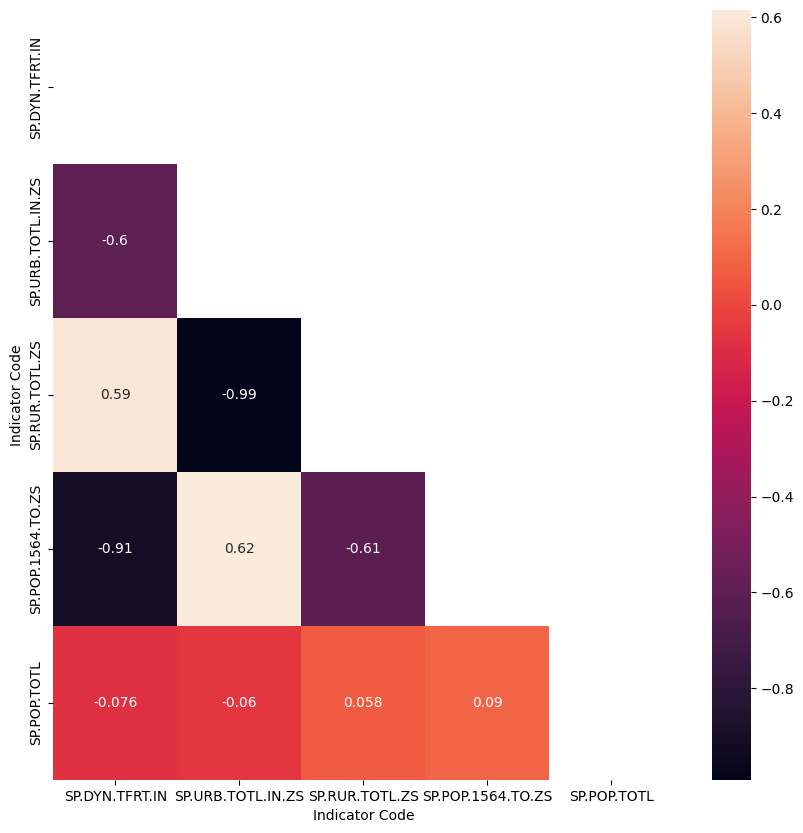

In [180]:
plt.figure(figsize=(10, 10))
corr = df_x_4[non_corr_features].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

In [181]:
corr

Indicator Code     SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
Indicator Code                                                         
SP.DYN.TFRT.IN            1.00000           -0.59602         0.59139   
SP.URB.TOTL.IN.ZS        -0.59602            1.00000        -0.99062   
SP.RUR.TOTL.ZS            0.59139           -0.99062         1.00000   
SP.POP.1564.TO.ZS        -0.90697            0.61513        -0.60567   
SP.POP.TOTL              -0.07623           -0.06014         0.05847   

Indicator Code     SP.POP.1564.TO.ZS  SP.POP.TOTL  
Indicator Code                                     
SP.DYN.TFRT.IN              -0.90697     -0.07623  
SP.URB.TOTL.IN.ZS            0.61513     -0.06014  
SP.RUR.TOTL.ZS              -0.60567      0.05847  
SP.POP.1564.TO.ZS            1.00000      0.09039  
SP.POP.TOTL                  0.09039      1.00000

In [184]:
kpi_dict['SP.DYN.TFRT.IN'], kpi_dict['SP.POP.1564.TO.ZS']

('Fertility rate, total (births per woman)',
 'Population ages 15-64 (% of total)')

In [187]:
df_x_5.head()

Indicator Code     SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
Country Code Year                                                      
0            1990         7.46600           18.31600        81.68400   
             1991         7.47900           18.59700        81.40300   
             1992         7.50200           18.88200        81.11800   
             1993         7.53500           19.17000        80.83000   
             1994         7.57200           19.46200        80.53800   

Indicator Code     SP.POP.1564.TO.ZS    SP.POP.TOTL  
Country Code Year                                    
0            1990           49.72776 12067570.00000  
             1991           49.74927 12789374.00000  
             1992           49.78082 13745630.00000  
             1993           49.78058 14824371.00000  
             1994           49.78894 15869967.00000

In [224]:
df_x_2[target_variable].isna().sum(), df_x_6[target_variable].isna().sum()

(0, 0)

In [223]:
df_x_6 = df_x_5.reset_index()
df_x_6[target_variable] = df_x_2[target_variable].values.tolist()
df_x_6.head()

Indicator Code  Country Code  Year  SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  \
0                          0  1990         7.46600           18.31600   
1                          0  1991         7.47900           18.59700   
2                          0  1992         7.50200           18.88200   
3                          0  1993         7.53500           19.17000   
4                          0  1994         7.57200           19.46200   

Indicator Code  SP.RUR.TOTL.ZS  SP.POP.1564.TO.ZS    SP.POP.TOTL  \
0                     81.68400           49.72776 12067570.00000   
1                     81.40300           49.74927 12789374.00000   
2                     81.11800           49.78082 13745630.00000   
3                     80.83000           49.78058 14824371.00000   
4                     80.53800           49.78894 15869967.00000   

Indicator Code  SP.DYN.LE00.IN  
0                     49.86105  
1                     50.64098  
2                     51.36293  
3                     52.02188  
4                     52.61434

In [225]:
df_x_6.isna().any()

Indicator Code
Country Code         False
Year                 False
SP.DYN.TFRT.IN       False
SP.URB.TOTL.IN.ZS    False
SP.RUR.TOTL.ZS       False
SP.POP.1564.TO.ZS    False
SP.POP.TOTL          False
SP.DYN.LE00.IN       False
dtype: bool

In [227]:
df_x_6.to_csv('health_data_processed_4.csv', index=False)

In [228]:
y = df_x_6[target_variable]
X = df_x_6.drop(target_variable, axis=1)

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Country Code'])

In [230]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Random Forest Regressor

In [231]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [232]:
# Get feature importances from the trained model
importances_rf = rf_model.feature_importances_

# Instead of using 'selected_kpi_list', get the feature names directly from X_train
# This ensures the feature names match the importances array
feature_names = X_train.columns

# Create the DataFrame using the correct feature names
df_feature_importance_rf = pd.DataFrame({'Feature Code': feature_names, 'Gini Importance': importances_rf}).sort_values('Gini Importance', ascending=False)
df_feature_importance_rf['Feature Name'] = df_feature_importance_rf['Feature Code'].map(kpi_dict)
df_feature_importance_rf['Model'] = 'Random Forest Regressor'
df_feature_importance_rf

Feature Code  Gini Importance  \
2     SP.DYN.TFRT.IN          0.72326   
3  SP.URB.TOTL.IN.ZS          0.07451   
6        SP.POP.TOTL          0.06900   
0       Country Code          0.05364   
4     SP.RUR.TOTL.ZS          0.04041   
5  SP.POP.1564.TO.ZS          0.01993   
1               Year          0.01925   

                               Feature Name                    Model  
2  Fertility rate, total (births per woman)  Random Forest Regressor  
3             Urban population (% of total)  Random Forest Regressor  
6                         Population, total  Random Forest Regressor  
0                                       NaN  Random Forest Regressor  
4  Rural population (% of total population)  Random Forest Regressor  
5        Population ages 15-64 (% of total)  Random Forest Regressor  
1                                       NaN  Random Forest Regressor

In [233]:
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE): {mse_rf}')

Mean Squared Error (MSE): 1.4668692438684072


In [234]:
df_test_and_predicted_rf, df_actual_vs_predicted_rf = compare_actual_vs_predicted(X_test, y_test, y_pred_rf, 'Random Forest Regressor')
df_actual_vs_predicted_rf

Actual  Predicted                    Model
4337 81.80244   81.15262  Random Forest Regressor
3192 62.48029   62.31717  Random Forest Regressor
4122 50.76241   50.66383  Random Forest Regressor
2357 55.69929   56.31417  Random Forest Regressor
3962 77.95122   77.94597  Random Forest Regressor
...       ...        ...                      ...
5003 44.27249   46.21594  Random Forest Regressor
3145 49.29859   54.17154  Random Forest Regressor
4370 70.67441   69.49943  Random Forest Regressor
936  69.03051   67.37506  Random Forest Regressor
2001 80.97883   80.82273  Random Forest Regressor

[1009 rows x 3 columns]

In [235]:
df_test_and_predicted_rf[['Country Code', 'Country Name', 'Year', 'Actual', 'Predicted']]

Country Code          Country Name  Year   Actual  Predicted
4337           166                Sweden  2011 81.80244   81.15262
3192           122               Namibia  2010 62.48029   62.31717
4122           158           South Sudan  2004 50.76241   50.66383
2357            90                 Kenya  2007 55.69929   56.31417
3962           152             Singapore  2000 77.95122   77.94597
...            ...                   ...   ...      ...        ...
5003           192                Zambia  2001 44.27249   46.21594
3145           120            Mozambique  2015 49.29859   54.17154
4370           168  Syrian Arab Republic  1992 70.67441   69.49943
936             36                 China  1990 69.03051   67.37506
2001            76  Hong Kong SAR, China  2015 80.97883   80.82273

[1009 rows x 5 columns]

In [236]:
plot_kpi(df_test_and_predicted_rf, 'Year', 'Actual', hue_col='Country Code')
plot_kpi(df_test_and_predicted_rf, 'Year', 'Predicted', hue_col='Country Code')

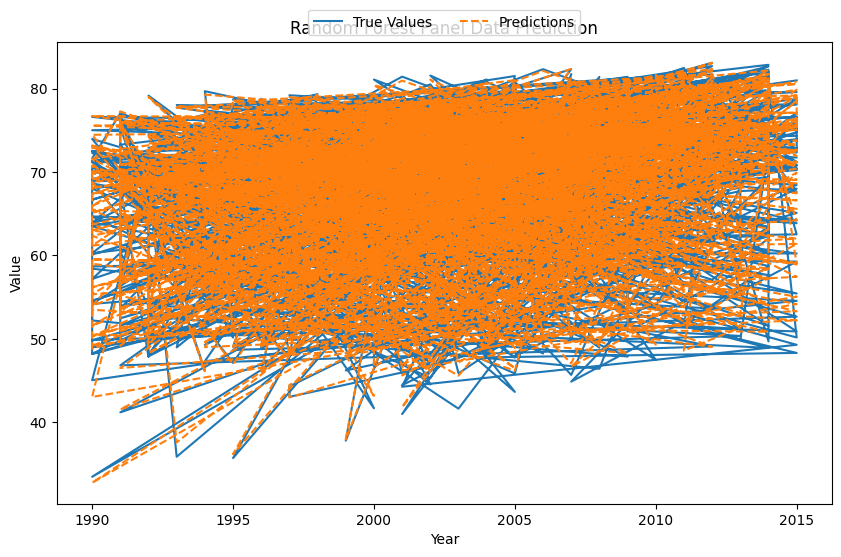

In [237]:
plot_results(df_test_and_predicted_rf, 'Random Forest')

## XGBoost Regressor

In [238]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=3)
for col in X_train.select_dtypes(include=['object']).columns:
    try:
        X_train[col] = pd.to_numeric(X_train[col])
        X_test[col] = pd.to_numeric(X_test[col]) # Apply the same transformation to X_test
    except ValueError:
        print(f"Could not convert column '{col}' to numeric. You might need to handle it differently.")

# Now you can fit the model:
xgb_model.fit(X_train, y_train)
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model's performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error: {mse_xgb}')

Mean Squared Error: 9.251467935242166


In [239]:
# Get feature importances from the trained model
importances_xgb = xgb_model.feature_importances_

# Instead of using 'selected_kpi_list', get the feature names directly from X_train
# This ensures the feature names match the importances array
feature_names = X_train.columns

# Create the DataFrame using the correct feature names
df_feature_importance_xgb = pd.DataFrame({'Feature Code': feature_names, 'Gini Importance': importances_xgb}).sort_values('Gini Importance', ascending=False)
df_feature_importance_xgb['Feature Name'] = df_feature_importance_xgb['Feature Code'].map(kpi_dict)
df_feature_importance_xgb['Model'] = 'XGBoost Regressor'
df_feature_importance_xgb

Feature Code  Gini Importance  \
2     SP.DYN.TFRT.IN          0.63028   
3  SP.URB.TOTL.IN.ZS          0.10303   
5  SP.POP.1564.TO.ZS          0.08640   
4     SP.RUR.TOTL.ZS          0.08604   
6        SP.POP.TOTL          0.04483   
0       Country Code          0.03009   
1               Year          0.01933   

                               Feature Name              Model  
2  Fertility rate, total (births per woman)  XGBoost Regressor  
3             Urban population (% of total)  XGBoost Regressor  
5        Population ages 15-64 (% of total)  XGBoost Regressor  
4  Rural population (% of total population)  XGBoost Regressor  
6                         Population, total  XGBoost Regressor  
0                                       NaN  XGBoost Regressor  
1                                       NaN  XGBoost Regressor

In [240]:
df_test_and_predicted_xgb, df_actual_vs_predicted_xgb = compare_actual_vs_predicted(X_test, y_test, y_pred_xgb, 'XGBoost Regressor')
df_actual_vs_predicted_xgb

Actual  Predicted              Model
4337 81.80244   80.47077  XGBoost Regressor
3192 62.48029   63.37218  XGBoost Regressor
4122 50.76241   50.70793  XGBoost Regressor
2357 55.69929   57.15021  XGBoost Regressor
3962 77.95122   77.30136  XGBoost Regressor
...       ...        ...                ...
5003 44.27249   45.21980  XGBoost Regressor
3145 49.29859   53.78153  XGBoost Regressor
4370 70.67441   65.13064  XGBoost Regressor
936  69.03051   67.96341  XGBoost Regressor
2001 80.97883   80.79263  XGBoost Regressor

[1009 rows x 3 columns]

In [241]:
df_test_and_predicted_xgb[['Country Code', 'Country Name', 'Year', 'Actual', 'Predicted']]

Country Code          Country Name  Year   Actual  Predicted
4337           166                Sweden  2011 81.80244   80.47077
3192           122               Namibia  2010 62.48029   63.37218
4122           158           South Sudan  2004 50.76241   50.70793
2357            90                 Kenya  2007 55.69929   57.15021
3962           152             Singapore  2000 77.95122   77.30136
...            ...                   ...   ...      ...        ...
5003           192                Zambia  2001 44.27249   45.21980
3145           120            Mozambique  2015 49.29859   53.78153
4370           168  Syrian Arab Republic  1992 70.67441   65.13064
936             36                 China  1990 69.03051   67.96341
2001            76  Hong Kong SAR, China  2015 80.97883   80.79263

[1009 rows x 5 columns]

In [242]:
plot_kpi(df_test_and_predicted_xgb, 'Year', 'Actual', hue_col='Country Code')
plot_kpi(df_test_and_predicted_xgb, 'Year', 'Predicted', hue_col='Country Code')

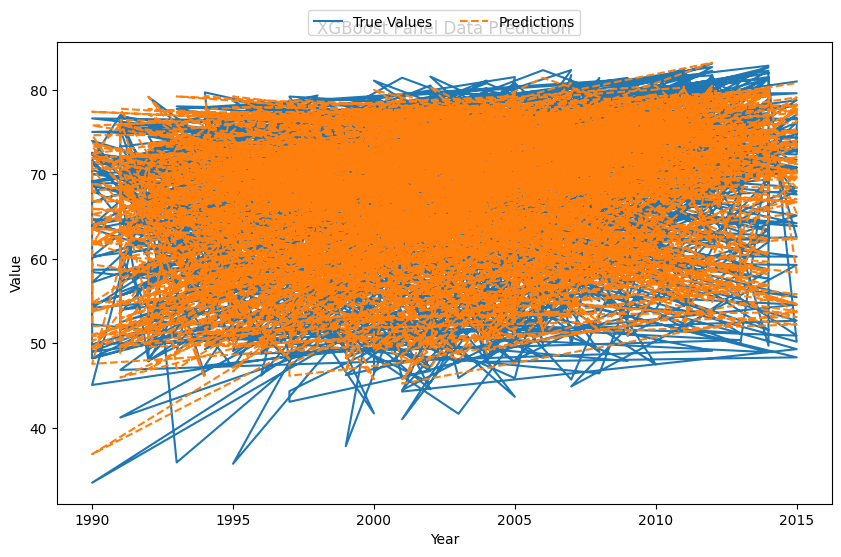

In [243]:
plot_results(df_test_and_predicted_xgb, 'XGBoost')

##LightGBM Regressor

In [244]:
# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.05, max_depth=3)

le = LabelEncoder()
y_train_1 = y_train.to_string()
y_test_1 = y_test.to_string()

#y_train['SP.DYN.LE00.IN'] = le.fit_transform(y_train['SP.DYN.LE00.IN'].astype(str))
#y_test['SP.DYN.LE00.IN'] = le.transform(y_test['SP.DYN.LE00.IN'].astype(str))

# After applying one of the above options, retrain the model:
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgb_model.predict(X_test)

# Evaluate the model's performance
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
print(f'Mean Squared Error: {mse_lgbm}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 4035, number of used features: 7
[LightGBM] [Info] Start training from score 67.659025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [245]:
# Get feature importances from the trained model
importances_lgb = lgb_model.feature_importances_

# Instead of using 'selected_kpi_list', get the feature names directly from X_train
# This ensures the feature names match the importances array
feature_names = X_train.columns

# Create the DataFrame using the correct feature names
df_feature_importance_lgb = pd.DataFrame({'Feature Code': feature_names, 'Gini Importance': importances_lgb}).sort_values('Gini Importance', ascending=False)
df_feature_importance_lgb['Feature Name'] = df_feature_importance_lgb['Feature Code'].map(kpi_dict)
df_feature_importance_lgb['Model'] = 'LightGBM Regressor'
df_feature_importance_lgb

Feature Code  Gini Importance  \
2     SP.DYN.TFRT.IN              153   
0       Country Code              142   
6        SP.POP.TOTL              114   
3  SP.URB.TOTL.IN.ZS              105   
5  SP.POP.1564.TO.ZS               58   
1               Year               48   
4     SP.RUR.TOTL.ZS               40   

                               Feature Name               Model  
2  Fertility rate, total (births per woman)  LightGBM Regressor  
0                                       NaN  LightGBM Regressor  
6                         Population, total  LightGBM Regressor  
3             Urban population (% of total)  LightGBM Regressor  
5        Population ages 15-64 (% of total)  LightGBM Regressor  
1                                       NaN  LightGBM Regressor  
4  Rural population (% of total population)  LightGBM Regressor

In [246]:
df_test_and_predicted_lgbm, df_actual_vs_predicted_lgbm = compare_actual_vs_predicted(X_test, y_test, y_pred_lgbm, 'LightGBM Regressor')
df_actual_vs_predicted_lgbm

Actual  Predicted               Model
4337 81.80244   79.09895  LightGBM Regressor
3192 62.48029   63.83845  LightGBM Regressor
4122 50.76241   50.45746  LightGBM Regressor
2357 55.69929   58.60255  LightGBM Regressor
3962 77.95122   77.37461  LightGBM Regressor
...       ...        ...                 ...
5003 44.27249   48.29654  LightGBM Regressor
3145 49.29859   54.98519  LightGBM Regressor
4370 70.67441   63.69857  LightGBM Regressor
936  69.03051   67.43906  LightGBM Regressor
2001 80.97883   79.42710  LightGBM Regressor

[1009 rows x 3 columns]

In [247]:
df_test_and_predicted_lgbm[['Country Code', 'Country Name', 'Year', 'Actual', 'Predicted']]

Country Code          Country Name  Year   Actual  Predicted
4337           166                Sweden  2011 81.80244   79.09895
3192           122               Namibia  2010 62.48029   63.83845
4122           158           South Sudan  2004 50.76241   50.45746
2357            90                 Kenya  2007 55.69929   58.60255
3962           152             Singapore  2000 77.95122   77.37461
...            ...                   ...   ...      ...        ...
5003           192                Zambia  2001 44.27249   48.29654
3145           120            Mozambique  2015 49.29859   54.98519
4370           168  Syrian Arab Republic  1992 70.67441   63.69857
936             36                 China  1990 69.03051   67.43906
2001            76  Hong Kong SAR, China  2015 80.97883   79.42710

[1009 rows x 5 columns]

In [248]:
plot_kpi(df_test_and_predicted_lgbm, 'Year', 'Actual', hue_col='Country Code')
plot_kpi(df_test_and_predicted_lgbm, 'Year', 'Predicted', hue_col='Country Code')

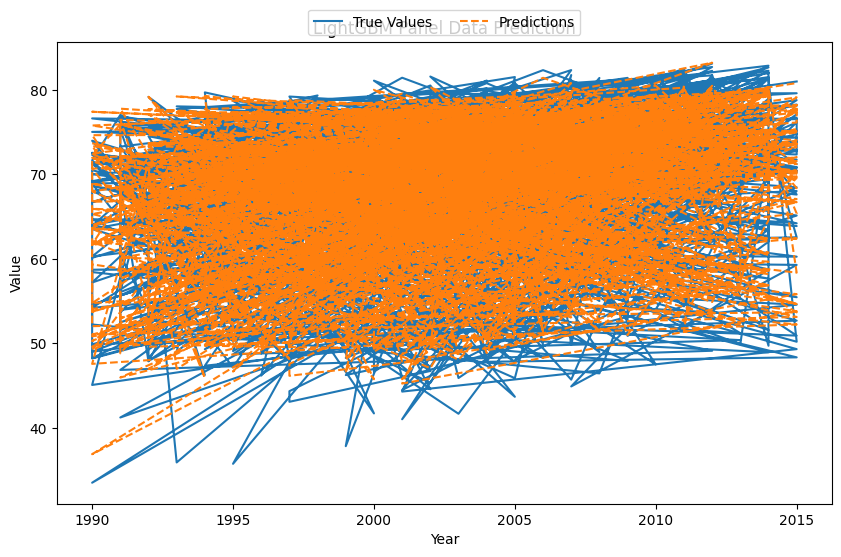

In [249]:
plot_results(df_test_and_predicted_xgb, 'LightGBM')

##Catboost Regressor

In [250]:
# Initialize the CatBoost model
catboost_model = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.1,
                                   depth=6,
                                   verbose=200)

# Train the model
catboost_model.fit(X_train, y_train)
# Make predictions
y_pred_catboost = catboost_model.predict(X_test)

# Evaluate the model's performance
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
print(f'Mean Squared Error: {mse_catboost}')

0:	learn: 9.1338048	total: 7.88ms	remaining: 7.87s
200:	learn: 1.5561657	total: 481ms	remaining: 1.91s
400:	learn: 0.8569595	total: 882ms	remaining: 1.32s
600:	learn: 0.5974578	total: 1.3s	remaining: 862ms
800:	learn: 0.4573396	total: 1.74s	remaining: 432ms
999:	learn: 0.3655072	total: 2.16s	remaining: 0us
Mean Squared Error: 0.5793765187344353


In [251]:
# Get feature importances from the trained model
importances_catboost = catboost_model.feature_importances_

# Instead of using 'selected_kpi_list', get the feature names directly from X_train
# This ensures the feature names match the importances array
feature_names = X_train.columns

# Create the DataFrame using the correct feature names
df_feature_importance_catboost = pd.DataFrame({'Feature Code': feature_names, 'Gini Importance': importances_catboost}).sort_values('Gini Importance', ascending=False)
df_feature_importance_catboost['Feature Name'] = df_feature_importance_catboost['Feature Code'].map(kpi_dict)
df_feature_importance_catboost['Model'] = 'CatBoost Regressor'
df_feature_importance_catboost

Feature Code  Gini Importance  \
2     SP.DYN.TFRT.IN         29.30134   
0       Country Code         20.36362   
6        SP.POP.TOTL         17.89110   
3  SP.URB.TOTL.IN.ZS          9.95250   
5  SP.POP.1564.TO.ZS          9.84842   
4     SP.RUR.TOTL.ZS          8.68957   
1               Year          3.95345   

                               Feature Name               Model  
2  Fertility rate, total (births per woman)  CatBoost Regressor  
0                                       NaN  CatBoost Regressor  
6                         Population, total  CatBoost Regressor  
3             Urban population (% of total)  CatBoost Regressor  
5        Population ages 15-64 (% of total)  CatBoost Regressor  
4  Rural population (% of total population)  CatBoost Regressor  
1                                       NaN  CatBoost Regressor

In [252]:
df_test_and_predicted_catboost, df_actual_vs_predicted_catboost = compare_actual_vs_predicted(X_test, y_test, y_pred_catboost, 'CatBoost Regressor')
df_test_and_predicted_catboost

Country Code  Year  SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
4337           166  2011         1.90000           85.21000        14.79000   
3192           122  2010         3.60500           41.61600        58.38400   
4122           158  2004         5.88500           17.02300        82.97700   
2357            90  2007         4.82500           22.42000        77.58000   
3962           152  2000         1.44388          100.00000        45.58744   
...            ...   ...             ...                ...             ...   
5003           192  2001         6.08000           34.95800        65.04200   
3145           120  2015         5.79164           32.21400        67.78600   
4370           168  1992         4.92500           49.34700        50.65300   
936             36  1990         2.42800           26.44200        73.55800   
2001            76  2015         1.12056          100.00000         0.22400   

      SP.POP.1564.TO.ZS      SP.POP.TOTL   Actual  Predicted  \
4337           64.99840    9449213.00000 81.80244   81.75177   
3192           58.47734    2193643.00000 62.48029   61.89541   
4122           52.35822    7784488.00000 50.76241   50.50221   
2357           54.54642   37250540.00000 55.69929   56.66342   
3962           71.20012    4027887.00000 77.95122   78.12678   
...                 ...              ...      ...        ...   
5003           50.63910   10861238.00000 44.27249   44.91198   
3145           51.34779   27977863.00000 49.29859   47.38993   
4370           51.14020   13186187.00000 70.67441   70.70192   
936            65.81603 1135185000.00000 69.03051   68.44936   
2001           72.97881    7305700.00000 80.97883   81.06323   

                   Model          Country Name  
4337  CatBoost Regressor                Sweden  
3192  CatBoost Regressor               Namibia  
4122  CatBoost Regressor           South Sudan  
2357  CatBoost Regressor                 Kenya  
3962  CatBoost Regressor             Singapore  
...                  ...                   ...  
5003  CatBoost Regressor                Zambia  
3145  CatBoost Regressor            Mozambique  
4370  CatBoost Regressor  Syrian Arab Republic  
936   CatBoost Regressor                 China  
2001  CatBoost Regressor  Hong Kong SAR, China  

[1009 rows x 11 columns]

In [253]:
df_test_and_predicted_catboost[['Country Code', 'Country Name', 'Year', 'Actual', 'Predicted']]

Country Code          Country Name  Year   Actual  Predicted
4337           166                Sweden  2011 81.80244   81.75177
3192           122               Namibia  2010 62.48029   61.89541
4122           158           South Sudan  2004 50.76241   50.50221
2357            90                 Kenya  2007 55.69929   56.66342
3962           152             Singapore  2000 77.95122   78.12678
...            ...                   ...   ...      ...        ...
5003           192                Zambia  2001 44.27249   44.91198
3145           120            Mozambique  2015 49.29859   47.38993
4370           168  Syrian Arab Republic  1992 70.67441   70.70192
936             36                 China  1990 69.03051   68.44936
2001            76  Hong Kong SAR, China  2015 80.97883   81.06323

[1009 rows x 5 columns]

In [254]:
plot_kpi(df_test_and_predicted_catboost, 'Year', 'Actual', hue_col='Country Code')
plot_kpi(df_test_and_predicted_catboost, 'Year', 'Predicted', hue_col='Country Code')

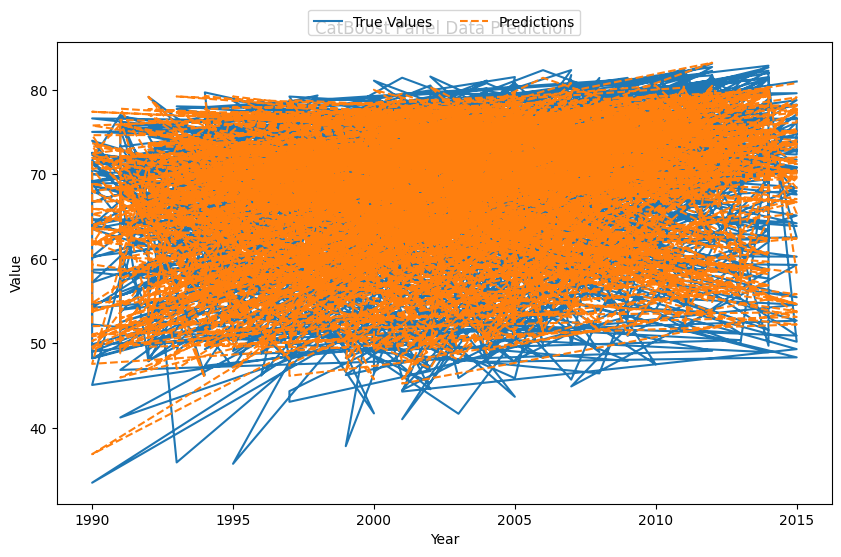

In [255]:
plot_results(df_test_and_predicted_xgb, 'CatBoost')

##SVM Regressor

In [259]:
# Initialize the Support Vector Regressor
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Train the model
svr.fit(X_train, y_train)

# Predict on the test set
y_pred_svr = svr.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f'Mean Squared Error: {mse_svr}')

Mean Squared Error: 99.59088917177631


It really performed so bad and predicted constant value across.

In [260]:
df_test_and_predicted_svr, df_actual_vs_predicted_svr = compare_actual_vs_predicted(X_test, y_test, y_pred_svr, 'Support Vector Regressor')
df_test_and_predicted_svr

Country Code  Year  SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
4337           166  2011         1.90000           85.21000        14.79000   
3192           122  2010         3.60500           41.61600        58.38400   
4122           158  2004         5.88500           17.02300        82.97700   
2357            90  2007         4.82500           22.42000        77.58000   
3962           152  2000         1.44388          100.00000        45.58744   
...            ...   ...             ...                ...             ...   
5003           192  2001         6.08000           34.95800        65.04200   
3145           120  2015         5.79164           32.21400        67.78600   
4370           168  1992         4.92500           49.34700        50.65300   
936             36  1990         2.42800           26.44200        73.55800   
2001            76  2015         1.12056          100.00000         0.22400   

      SP.POP.1564.TO.ZS      SP.POP.TOTL   Actual  Predicted  \
4337           64.99840    9449213.00000 81.80244   67.63549   
3192           58.47734    2193643.00000 62.48029   67.63549   
4122           52.35822    7784488.00000 50.76241   67.63549   
2357           54.54642   37250540.00000 55.69929   67.63549   
3962           71.20012    4027887.00000 77.95122   67.63549   
...                 ...              ...      ...        ...   
5003           50.63910   10861238.00000 44.27249   67.63549   
3145           51.34779   27977863.00000 49.29859   67.63549   
4370           51.14020   13186187.00000 70.67441   67.63549   
936            65.81603 1135185000.00000 69.03051   67.63549   
2001           72.97881    7305700.00000 80.97883   67.63549   

                         Model          Country Name  
4337  Support Vector Regressor                Sweden  
3192  Support Vector Regressor               Namibia  
4122  Support Vector Regressor           South Sudan  
2357  Support Vector Regressor                 Kenya  
3962  Support Vector Regressor             Singapore  
...                        ...                   ...  
5003  Support Vector Regressor                Zambia  
3145  Support Vector Regressor            Mozambique  
4370  Support Vector Regressor  Syrian Arab Republic  
936   Support Vector Regressor                 China  
2001  Support Vector Regressor  Hong Kong SAR, China  

[1009 rows x 11 columns]

In [261]:
df_test_and_predicted_svr[['Country Code', 'Country Name', 'Year', 'Actual', 'Predicted']]

Country Code          Country Name  Year   Actual  Predicted
4337           166                Sweden  2011 81.80244   67.63549
3192           122               Namibia  2010 62.48029   67.63549
4122           158           South Sudan  2004 50.76241   67.63549
2357            90                 Kenya  2007 55.69929   67.63549
3962           152             Singapore  2000 77.95122   67.63549
...            ...                   ...   ...      ...        ...
5003           192                Zambia  2001 44.27249   67.63549
3145           120            Mozambique  2015 49.29859   67.63549
4370           168  Syrian Arab Republic  1992 70.67441   67.63549
936             36                 China  1990 69.03051   67.63549
2001            76  Hong Kong SAR, China  2015 80.97883   67.63549

[1009 rows x 5 columns]

##Panel Data Regression

In [265]:
df_x_6 = df_x_5.reset_index()
df_x_6['Country Name'] = df_x_6['Country Code'].map(country_dict)
df_x_6.drop('Country Code', axis=1, inplace=True)
df_x_6.set_index(['Country Name', 'Year'], inplace=True)
df_x_6.head()

Indicator Code     SP.DYN.TFRT.IN  SP.URB.TOTL.IN.ZS  SP.RUR.TOTL.ZS  \
Country Name Year                                                      
Afghanistan  1990         7.46600           18.31600        81.68400   
             1991         7.47900           18.59700        81.40300   
             1992         7.50200           18.88200        81.11800   
             1993         7.53500           19.17000        80.83000   
             1994         7.57200           19.46200        80.53800   

Indicator Code     SP.POP.1564.TO.ZS    SP.POP.TOTL  
Country Name Year                                    
Afghanistan  1990           49.72776 12067570.00000  
             1991           49.74927 12789374.00000  
             1992           49.78082 13745630.00000  
             1993           49.78058 14824371.00000  
             1994           49.78894 15869967.00000

In [266]:
independent_variables = [col for col in df_x_6.columns if col != target_variable]

In [273]:
# Fit the fixed effects model
model_fe = PanelOLS(df_x_4[target_variable], df_x_6[independent_variables], entity_effects = True)
result_fe = model_fe.fit()
print(result_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:         SP.DYN.LE00.IN   R-squared:                        0.4092
Estimator:                   PanelOLS   R-squared (Between):             -397.84
No. Observations:                5044   R-squared (Within):               0.4092
Date:                Sat, Nov 30 2024   R-squared (Overall):             -397.22
Time:                        01:09:22   Log-likelihood                -1.086e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      671.02
Entities:                         194   P-value                           0.0000
Avg Obs:                       26.000   Distribution:                  F(5,4845)
Min Obs:                       26.000                                           
Max Obs:                       26.000   F-statistic (robust):             671.02
                            


*   40.92% of the variation between entities is explained by the model.
*   40.92% of the variation within each entity (likely a country or region) is explained by the model.
*   -397.22 – A negative R-squared overall suggests the model may not explain much of the overall variation.

The regression indicates significant relationships between various independent variables (e.g., urban and rural populations) and life expectancy.
The model shows that urbanization and the percentage of the population in the working-age bracket are important predictors of life expectancy.
The results suggest that a fixed-effects model is appropriate due to the significance of the F-test for poolability.

Summary:
The model tries to explain life expectancy based on various independent variables, such as fertility rate, urbanization, rural population, working-age population, and total population.
Significant negative effects on life expectancy are observed for fertility rate and working-age population.
Positive effects on life expectancy are found for urbanization and rural population.
The model is statistically significant and the coefficients for the predictors are meaningful.

In [272]:
# Random effect model
model_re = PanelOLS(df_x_4[target_variable], df_x_6[independent_variables], entity_effects=False)
# The 'method' argument is now passed to the fit() method
result_re = model_re.fit(cov_type='clustered', cluster_entity=True)  # Example using 'clustered' cov_type
print(result_re)

                          PanelOLS Estimation Summary                           
Dep. Variable:         SP.DYN.LE00.IN   R-squared:                        0.9941
Estimator:                   PanelOLS   R-squared (Between):              0.9952
No. Observations:                5044   R-squared (Within):               0.2963
Date:                Sat, Nov 30 2024   R-squared (Overall):              0.9941
Time:                        01:09:10   Log-likelihood                -1.551e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.706e+05
Entities:                         194   P-value                           0.0000
Avg Obs:                       26.000   Distribution:                  F(5,5039)
Min Obs:                       26.000                                           
Max Obs:                       26.000   F-statistic (robust):          1.228e+04
                            

Some variables, like urban population percentage, have a significant positive relationship with life expectancy.
The model has good explanatory power, especially in explaining the differences between countries (R-squared (Between) = 0.9925).
While the overall model is significant, some variables like the working-age population have a non-significant effect.

In [274]:
# Time effect model
# Fit the model with time effects (instead of entity effects).
model_te = PanelOLS(df_x_4[target_variable], df_x_6[independent_variables], time_effects=True)

# Fit the model with clustered standard errors for more robust results.
result_te = model_te.fit(cov_type='clustered', cluster_entity=True)

# Print the model results.
print(result_te)

                          PanelOLS Estimation Summary                           
Dep. Variable:         SP.DYN.LE00.IN   R-squared:                        0.7579
Estimator:                   PanelOLS   R-squared (Between):             -0.4145
No. Observations:                5044   R-squared (Within):               0.3671
Date:                Sat, Nov 30 2024   R-squared (Overall):             -0.4133
Time:                        01:30:19   Log-likelihood                -1.503e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3138.8
Entities:                         194   P-value                           0.0000
Avg Obs:                       26.000   Distribution:                  F(5,5013)
Min Obs:                       26.000                                           
Max Obs:                       26.000   F-statistic (robust):             326.07
                            

This output represents a regression model that explains life expectancy using several socio-economic and demographic factors, with time effects accounted for. The results indicate which variables are significantly associated with life expectancy across different countries or regions.

In [280]:
# Assuming model_fe, model_re, and model_te are your PanelOLS model instances
hausman_test_results = {
    "FE": result_fe,
    "RE": result_re,
    "TE": result_te,  # Assuming you have a model_te for time effects
}

hausman_test = linearmodels.panel.results.compare(hausman_test_results)  # Compare the models
print(hausman_test)  # Print the results

                                Model Comparison                                
                                        FE                 RE                 TE
--------------------------------------------------------------------------------
Dep. Variable               SP.DYN.LE00.IN     SP.DYN.LE00.IN     SP.DYN.LE00.IN
Estimator                         PanelOLS           PanelOLS           PanelOLS
No. Observations                      5044               5044               5044
Cov. Est.                       Unadjusted          Clustered          Clustered
R-squared                           0.4092             0.9941             0.7579
R-Squared (Within)                  0.4092             0.2963             0.3671
R-Squared (Between)                -397.84             0.9952            -0.4145
R-Squared (Overall)                -397.22             0.9941            -0.4133
F-statistic                         671.02          1.706e+05             3138.8
P-value (F-stat)            

R-Squared:
Within: The R-squared for within-entity variation.
Between: The R-squared for between-entity (i.e., between countries) variation.
Overall: The overall R-squared, which represents how much of the total variation in life expectancy is explained by the model.
F-statistic: A measure of how well the model fits. The higher the value, the better the model explains the variation in the dependent variable.
P-value: A p-value of 0.0000 indicates that all the models are statistically significant.
Model Comparison Breakdown:
Fixed Effects (FE) Model:

R-Squared (Within): 0.4092 – This means that the model explains 40.92% of the variation within countries across time.
R-Squared (Between): -397.84 – This is negative, indicating that the model doesn't explain the between-country variation well.
Coefficient Estimates:
SP.DYN.TFRT.IN: Coefficient of -2.6620, which means that as the fertility rate increases, life expectancy tends to decrease. The p-value indicates that this result is statistically significant.
SP.POP.TOT: The population size has a very small positive effect on life expectancy.
Random Effects (RE) Model:

R-Squared (Within): 0.2963 – The model explains 29.63% of the within-country variation.
R-Squared (Between): 0.9952 – This indicates that the model does a much better job of explaining between-country variation.
F-statistic (Clustered): 1.706e+05, which is a much higher statistic compared to the Fixed Effects model, suggesting that the Random Effects model explains more of the total variation.
Key Insight: The RE model assumes that there is no correlation between the entity-specific effects and the independent variables, which is likely why it does better in explaining between-entity variation.
Time Effects (TE) Model:

R-Squared (Within): 0.3671 – Similar to the Fixed Effects model but slightly lower.
R-Squared (Between): -0.4143 – A very low value indicating that the model does not explain between-country variation effectively.
Coefficient Estimates: The coefficients are very similar to the other models but are focused on capturing time-specific variation.
Key Insight: This model is capturing the effects of time (e.g., global trends) on life expectancy across the countries.
Parameter Estimates and Statistical Significance:
SP.DYN.TFRT.IN (Fertility rate):
The coefficient is negative across all models, indicating that higher fertility rates are associated with lower life expectancy.
The p-value is low, indicating that this variable is statistically significant.
SP.URB.TOT.IN.ZS (Urbanization):
In the RE model, urbanization has a positive relationship with life expectancy, with a p-value of 0.0013, indicating statistical significance.
SP.POP.TOT (Total population):
The positive coefficient in the FE model and negative in RE and TE models suggests mixed findings, but the small effect and p-value of 0.0000 in all models suggest a significant effect.
F-test for Poolability:
The F-test for poolability assesses whether it is better to include entity effects (for the FE model) or not (for the RE model). A significant p-value here (0.0000) indicates that entity effects should be included (i.e., Fixed Effects is more appropriate in some cases).
Conclusion:
The Fixed Effects model focuses on the variation within countries over time, which is useful when you are concerned with how specific countries' variables change over time.
The Random Effects model accounts for both within- and between-country variation, which works well when the effects of individual countries are assumed to be uncorrelated with the independent variables.
The Time Effects model captures temporal trends, allowing us to account for global changes over time.
Based on R-squared and p-values, you can determine which model fits best based on your research question. However, the FE model would be preferable if you want to control for entity-specific unobserved characteristics.

# Observations



1.   Dataframe is wide.
2.   Not all year-country-indicator column is populated.
3.   Country Name includes both individual countries and conglomerates. Ex. Arab World.



# Considerations



1.   Consider to shift timeline
2.   Check the KPI column population per country to decide, consider a threshold where for a particular KPI, if x countries have populated data which is above the threshold, consider it.



# Research Questions

Which features affect "Life expectancy at birth, total (years)" across different regions and socio economic conditions ('High income', 'Middle income', 'Low & middle income', 'Lower middle income', 'Low income')?

# Exploratory Data Analysis - Matt

In [ ]:
pd.set_option('display.max_columns', None)
# health_df[health_df['Indicator Name'] == 'Literacy rate, youth total (% of people ages 15-24)'].info()

In [ ]:
income_range_df = health_df[health_df['Country Name'].isin(['High income', 'Low & middle income', ' Lower middle income', 'Low income', 'Middle income'])]
display(income_range_df.shape, income_range_df.head())

In [ ]:
ed_indicators = ['Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)',
                'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)',
                'Literacy rate, adult female (% of females ages 15 and above)',
                'Literacy rate, adult male (% of males ages 15 and above)',
                'Literacy rate, adult total (% of people ages 15 and above)',
                'Literacy rate, youth male (% of males ages 15-24)',
                'Literacy rate, youth total (% of people ages 15-24)',
                'Primary completion rate, female (% of relevant age group)',
                'Primary completion rate, male (% of relevant age group)',
                'Primary completion rate, total (% of relevant age group)',
                'Public spending on education, total (% of GDP)',
                'Ratio of school attendance of orphans to school attendance of non-orphans ages 10-14',
                'Ratio of young literate females to males (% ages 15-24)',
                'School enrollment, primary (% gross)',
                'School enrollment, primary (% net)',
                'School enrollment, primary, female (% gross)',
                'School enrollment, primary, female (% net)',
                'School enrollment, primary, male (% gross)',
                'School enrollment, primary, male (% net)',
                'School enrollment, secondary (% gross)',
                'School enrollment, secondary (% net)',
                'School enrollment, secondary, female (% gross)',
                'School enrollment, secondary, female (% net)',
                'School enrollment, secondary, male (% gross)',
                'School enrollment, secondary, male (% net)',
                'School enrollment, tertiary (% gross)',
                'School enrollment, tertiary, female (% gross)']

In [ ]:
# set number of rows to display
pd.set_option('display.max_rows', 150)
# drop all columns prior to 1970
columns_to_drop = [str(year) for year in range(1960, 1970)]
# income_range_df = income_range_df.drop(columns=columns_to_drop)
ed_df = income_range_df[income_range_df['Indicator Name'].isin(ed_indicators)].drop(columns=['Country Code', 'Indicator Code'])
ed_df
li_ed_df = ed_df[ed_df['Country Name'] == 'Low income'].drop(columns=['2014', '2015', 'Unnamed: 60'])
li_ed_df

In [ ]:
li_lit_df = li_ed_df[li_ed_df['Indicator Name'].isin([
    'Literacy rate, adult female (% of females ages 15 and above)',
    'Literacy rate, adult male (% of males ages 15 and above)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    'Literacy rate, youth male (% of males ages 15-24)',
    'Literacy rate, youth total (% of people ages 15-24)',
    'Literacy rate, youth female (% of females ages 15-24)'
])].dropna(axis=1).drop(columns='Country Name').set_index('Indicator Name')
li_lit_df

In [ ]:
df = li_lit_df.transpose()
df.plot(kind='line', figsize=(10, 4))
plt.xlabel('Year')
plt.ylabel('Literacy Rate (%)')
plt.title('Literacy Rates Over Time')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's look at formal education

In [ ]:
primary_completion_df = li_ed_df[li_ed_df['Indicator Name'].isin([
    'Primary completion rate, female (% of relevant age group)',
    'Primary completion rate, male (% of relevant age group)',
    'Primary completion rate, total (% of relevant age group)'
])].dropna(axis=1).drop(columns='Country Name').set_index('Indicator Name')
# primary_completion_df

In [ ]:
df = primary_completion_df.transpose()
df.plot(kind='line', figsize=(10, 4))
plt.title('Primary Completion Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Primary Completion Rate (%)')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
li_gni_df = health_df[health_df['Country Name'] == 'Low income']
li_gni_df = li_gni_df[li_gni_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)']
columns_to_drop = [str(year) for year in range(1960, 1988)]
li_gni_df = li_gni_df.drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60']).drop(columns=columns_to_drop)
li_gni_df.set_index('Indicator Name', inplace=True)
# li_gni_df

In [ ]:
li_gni_df = li_gni_df.transpose()
li_gni_df.plot(kind='line', figsize=(10, 4))
plt.title('GNI per Capita Over Time')
plt.xlabel('Year')
plt.ylabel('GNI per Capita')


In [ ]:
health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].describe()

In [ ]:
health_indicators = ['Prevalence of anemia among children (% of children under 5)',
       'Prevalence of anemia among non-pregnant women (% of women ages 15-49)',
       'Prevalence of anemia among pregnant women (%)',
       'Prevalence of anemia among women of reproductive age (% of women ages 15-49)',
       'Prevalence of HIV, female (% ages 15-24)',
       'Prevalence of HIV, male (% ages 15-24)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'Prevalence of overweight (% of adults)',
       'Prevalence of overweight (% of children under 5)',
       'Prevalence of overweight, female (% of children under 5)',
       'Prevalence of overweight, female (% of female adults)',
       'Prevalence of overweight, male (% of children under 5)',
       'Prevalence of overweight, male (% of male adults)',
       'Prevalence of severe wasting, weight for height (% of children under 5)',
       'Prevalence of severe wasting, weight for height, female (% of children under 5)',
       'Prevalence of severe wasting, weight for height, male (% of children under 5)',
       'Prevalence of syphilis (% of women attending antenatal care)',
       'Prevalence of tuberculosis (per 100,000 population)',
       'Prevalence of undernourishment (% of population)',
       'Prevalence of wasting (% of children under 5)',
       'Prevalence of wasting, female (% of children under 5)',
       'Prevalence of wasting, male (% of children under 5)',
       'Malnutrition prevalence, height for age (% of children under 5)',
       'Malnutrition prevalence, height for age, female (% of children under 5)',
       'Malnutrition prevalence, height for age, male (% of children under 5)',
       'Malnutrition prevalence, weight for age (% of children under 5)',
       'Malnutrition prevalence, weight for age, female (% of children under 5)',
       'Malnutrition prevalence, weight for age, male (% of children under 5)',
       'Maternal leave benefits (% of wages paid in covered period)',
       'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
       'Maternal mortality ratio (national estimate, per 100,000 live births)',
       'Mortality caused by road traffic injury (per 100,000 people)',
       'Mortality rate, adult, female (per 1,000 female adults)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, infant, female (per 1,000 live births)',
       'Mortality rate, infant, male (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000)',
       'Mortality rate, under-5, female (per 1,000)',
       'Mortality rate, under-5, male (per 1,000)']

In [ ]:
li_health_df = health_df[health_df['Indicator Name'].isin(health_indicators)][health_df['Country Name'] == 'Low income'].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
li_health_df

In [ ]:
# li_health_df.isna().sum()

In [ ]:
li_adult_mortality_df = li_health_df[li_health_df['Indicator Name'].isin(['Mortality rate, adult, female (per 1,000 female adults)',
                                                                          'Mortality rate, adult, male (per 1,000 male adults)'])]
li_adult_mortality_df



In [ ]:
li_adult_mortality_df = li_adult_mortality_df.set_index('Indicator Name').transpose()



In [ ]:
# rename index to "Year"
li_adult_mortality_df.index.name = 'Year'
li_adult_mortality_df

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4))
# add more space between plots
plt.subplots_adjust(hspace=0.5)

# plot adult mortality rate
axes[0][0].plot(li_adult_mortality_df.index, li_adult_mortality_df)
axes[0][0].set_title('Adult Mortality Rate by Year')
# only display xticks for every five years
axes[0][0].set_xticks(range(0, len(li_adult_mortality_df.index), 5))
axes[0][0].set_xticklabels(li_adult_mortality_df.index[::5])

# plot primary school completion rate
axes[0][1].plot(primary_completion_df.transpose().index, primary_completion_df.transpose())
axes[0][1].set_title('Primary School Completion Rate by Year')
axes[0][1].set_xticks(range(0, len(primary_completion_df.transpose().index), 5))
axes[0][1].set_xticklabels(primary_completion_df.transpose().index[::5])

# plot GNI per capita by year
axes[1][0].plot(li_gni_df.index, li_gni_df)
axes[1][0].set_title('GNI per Capita by Year')
axes[1][0].set_xticks(range(0, len(li_gni_df.index), 5))
axes[1][0].set_xticklabels(li_gni_df.index[::5])

# plot literacy rates over time
axes[1][1].plot(li_lit_df.transpose().index, li_lit_df.transpose())
axes[1][1].set_title('Literacy Rates by Year')


# Conclusions So Far
My hypothesis was that increasing education levels in low income countries might have a positive effect on life expectancy (or, as seen in the plots above, a decreasing effect on mortality rates). It seems clear, however, that at least in a broad sense, any effects of education are overshadowed by general wealth levels. That is to say, there's a definite correlation between education levels (as measured by primary school completion and literacy rates) and a decrease in adulkt mortality rates. However, GNI per capita seems to correlate even better with mortality rates than the chosen education metrics. (Note the dip and then plateau in GNI matches the brief rise in mortality rate from roughly 1990 to 2000.) This means we can't tell if education itself has anything to do with decreasing adult mortality rates, or if increased education and lower mortality rates are both effects of increasing wealth. Alternatively, it could be the case that education is the root cause of both decreasing mortality and increasing wealth.

As far as predictions go, this is not necessarily a problem. We could build a model to predict mortality rate that takes these factors (and others) into consideration. When it comes to elucidating causes and suggesting interventions, however, we want to know what has the most impact.

# Next Direction to Pursue
## Dig Deeper into the metrics
I suspect that the data I've examined so far will prove fairly representative, but I want to take a look at similar indicators to see if they follow the same patterns. I'll look at education indicators and health indicators in different categories - adult, youth - and in more specific areas, such HIV rates (which may correlate with sexual health education) and malaria incidence.

In [ ]:
reproductive_ed_indicators = [
    '% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)',
    '% of males ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)'
    'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions',
    'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)',
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Condom use with non regular partner, % adults(15-49), female',
    'Condom use with non regular partner, % adults(15-49), male',
    'Condom use, population ages 15-24, female (% of females ages 15-24)',
    'Condom use, population ages 15-24, male (% of males ages 15-24)',
    'Contraceptive prevalence, any methods (% of women ages 15-49)',
    'Contraceptive prevalence, modern methods (% of women ages 15-49)'
    ]
hiv_outcomes = [
    'Children (0-14) living with HIV',
    'Children (ages 0-14) newly infected with HIV',
    'Children orphaned by HIV/AIDS',
    'Prevalence of HIV, female (% ages 15-24)',
    'Prevalence of HIV, male (% ages 15-24)',
    'Prevalence of HIV, total (% of population ages 15-49)',
    'Adults (ages 15+) and children (0-14 years) living with HIV',
    'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
    'Adults (ages 15+) living with HIV',
    'Adults (ages 15+) newly infected with HIV'
    ]

In [ ]:
low_income_df = health_df[health_df['Country Name'] == 'Low income']
reproductive_ed_df = low_income_df[low_income_df['Indicator Name'].isin(reproductive_ed_indicators)].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
reproductive_ed_df

In [ ]:
reproductive_ed_df = reproductive_ed_df.dropna(axis=0, thresh=2)

In [ ]:
reproductive_ed_df

In [ ]:
reproductive_ed_df.set_index('Indicator Name').transpose().fillna(method='ffill').plot(kind='line', figsize=(10, 4))
plt.title('Reproductive Health Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')

In [ ]:
hiv_df = low_income_df[low_income_df['Indicator Name'].isin(hiv_outcomes)].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
hiv_df

In [ ]:
hiv_df = hiv_df.set_index('Indicator Name').dropna(thresh=5).transpose().fillna(method='ffill')
hiv_df.plot(kind='line', figsize=(10, 4))
plt.title('HIV Outcomes Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')

# Reproductive Health
Here we see that higher contraceptive use, regardless of the specific method, is correlated with lower adolescent birth rates and lower prevalence of HIV over time.

Let's also look at:
* malaria
* spending on education
* education beyond primary
* separate countries that fall into low income level



In [ ]:
health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].describe()

In [ ]:
gni_df = health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].drop(columns=['Country Code', 'Indicator Code', 'Indicator Name', 'Unnamed: 60'])
gni_df

In [ ]:
# let's plot gni_df
gni_df.set_index('Country Name').transpose().plot(kind='line', figsize=(10, 4))
plt.title('GNI per Capita Over Time')
# no legend
plt.legend().set_visible(False)

That's not very informative...

# Let's Look at Individual Low-Income Countries
We'll create a threshold, based on an average of each country's GNI per capita over time, and examine the data and trends for all countries under that threshold.

In [ ]:
# let's find average gni for every Country Name in gni_df
gni_df[gni_df['Country Name'] == 'Low income']

In [ ]:
avg_gni = gni_df.bfill(axis=1)
avg_gni = avg_gni.set_index('Country Name')
avg_gni = avg_gni.ffill(axis=1).sort_values(by='Country Name')
avg_gni = avg_gni.ffill(axis=1).dropna()
avg_gni = avg_gni.mean(axis=1)
avg_gni.describe()

In [ ]:
avg_gni

I can use the info above to create my own list of low income countries and see if anything interesting shows up in the numbers for that group that is hidden in the aggregate view where country name = 'Low income'. Let's use the average value for the 'Low income' Country Name as our threshold, but let's bump it up a little bit to include a few more countries.

In [ ]:
avg_gni['Low income']

In [ ]:
threshhold = avg_gni['Low income'] + 150

In [ ]:
# build a custom list of low income countries
low_income_countries = avg_gni[avg_gni < threshhold].index.tolist()
low_income_countries.remove('Least developed countries: UN classification')  # remove the aggregate names
low_income_countries.remove('Low income')
low_income_countries.remove('Heavily indebted poor countries (HIPC)')
low_income_countries

In [ ]:
# filter the main df to include only those countries in the new list
new_df = health_df[health_df['Country Name'].isin(low_income_countries)]
new_df

In [ ]:
# build a df of education indicators for the low income countries
new_ed_df = new_df[new_df['Indicator Name'].isin(ed_indicators)]
# new_ed_df

In [ ]:
# new_ed_df.info()
# there's no non-null data in the columns 1960-1969, or in "unnamed", so let's drop those
new_ed_df = new_ed_df.drop(columns=['Country Code', 'Indicator Code']).dropna(axis=1, how='all')
# new_ed_df

In [ ]:
female_youth_hiv_ed_df = new_ed_df[new_ed_df['Indicator Name'] == 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)'][['Country Name', '2005', '2006', '2010', '2014']].dropna(thresh=2)
# female_youth_hiv_ed_df
# 2005, 2006, 2010, 2014

In [ ]:
male_youth_hiv_ed_df = new_ed_df[new_ed_df['Indicator Name'] == 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)'][['Country Name', '2005', '2006', '2010', '2014']].dropna(thresh=2)
# male_youth_hiv_ed_df

In [ ]:
youth_hiv_ed_df = male_youth_hiv_ed_df.merge(female_youth_hiv_ed_df, how='outer', on="Country Name", suffixes=("_male", "_female"))
youth_hiv_ed_df

In [ ]:
big_hiv_df = new_df[new_df['Indicator Name'].isin(['Prevalence of HIV, female (% ages 15-24)', 'Prevalence of HIV, male (% ages 15-24)'])].dropna(thresh=5).drop(columns=['Country Code', 'Indicator Code']).dropna(axis=1, thresh=5)[['Country Name', '2005', '2006', '2010', '2014']].merge(youth_hiv_ed_df, how='inner', on="Country Name")

In [ ]:
df = new_df[new_df['Indicator Name'] == 'Prevalence of HIV, female (% ages 15-24)'][['Country Name', '2005', '2006', '2010', '2014']].merge(female_youth_hiv_ed_df, how='inner', on="Country Name", suffixes=('_hiv', '_ed')).dropna(axis=1, thresh=3)

In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
df_melted_hiv = df.melt(id_vars=['Country Name'], value_vars=['2005_hiv', '2006_hiv', '2010_hiv', '2014_hiv'],
                        var_name='Year', value_name='HIV')
df_melted_hiv['Year'] = df_melted_hiv['Year'].str.extract('(\d+)')

df_melted_ed = df.melt(id_vars=['Country Name'], value_vars=['2005_ed', '2006_ed', '2010_ed', '2014_ed'],
                       var_name='Year', value_name='Education')
df_melted_ed['Year'] = df_melted_ed['Year'].str.extract('(\d+)')

# Merge the two melted DataFrames
df_combined = pd.merge(df_melted_hiv, df_melted_ed, on=['Country Name', 'Year'])


In [ ]:
df_combined_cleaned = df_combined.dropna(subset=['HIV', 'Education'])

df_combined_cleaned

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot with all countries combined
plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df_combined_cleaned, x="Education", y="HIV", hue="Country Name", palette="tab20", alpha=0.8)
sns.regplot(data=df_combined_cleaned, x="Education", y="HIV", scatter=True)

# Add labels and title
plt.title("Correlation Between Education and HIV Prevalence Across Countries", fontsize=16)
plt.xlabel("HIV Education Level (%)", fontsize=14)
plt.ylabel("HIV Prevalence (%)", fontsize=14)
# plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



In [ ]:
adult_lit = new_df[new_df['Indicator Name'] == 'Literacy rate, adult total (% of people ages 15 and above)']
adult_lit

In [ ]:
ed_indicators